# NN 2.0

## Defining data functions

Import needed libraries

In [1]:
# imports
import pandas as pd
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Get data from file and remove columns with text

In [2]:
def get_swissvotes_data(now:int=651, since:int=299)->pd.DataFrame:
    import re
    
    dataset = pd.read_csv("../data/formatted/swissvotes_edited_nov_2021.csv", sep=';')
    
    regex = re.compile("pdev_.*")
    to_excl = list(filter(regex.match, dataset.columns))
    
    dataset.drop(columns=to_excl, inplace=True)
    dataset.drop(columns=["legisjahr"], inplace=True)
    dataset.drop(columns=["titel_kurz_d", "titel_kurz_f", "titel_off_d", "titel_off_f", "stichwort"], inplace=True)
    dataset.drop(columns=["swissvoteslink", "anzahl", "anneepolitique", "bkchrono_de", "bkchrono_fr"], inplace=True)
    dataset.drop(columns=["curiavista_de", "curiavista_fr", "urheber", "bkresults_de", "bkresults_fr"], inplace=True)
    dataset.drop(columns=["bfsmap_de", "bfsmap_fr", "nach_cockpit_d", "nach_cockpit_f", "nach_cockpit_e"], inplace=True)
    dataset = dataset[dataset["anr"] < now] # we don't care about future votes
    dataset = dataset[dataset["anr"] >= since]
    
    return dataset
print(f"Defined {get_swissvotes_data}")

Defined <function get_swissvotes_data at 0x000001B7CA890D30>


In [3]:
def get_left_right_data(now:int=651, since:int=299)->pd.DataFrame:
    col_names = ["anr", "datum", "titel_kurz_d", "ja_proz", "links_rechts", "kons_prog"]
    dataset = pd.read_csv("../data/formatted/brj_lire_konslib_edited.csv", sep=',')
    dataset = dataset[dataset["anr"].map(lambda x: x.replace(',', '.')).astype(float) < now]
    dataset = dataset.replace("#ZAHL!", np.nan).replace("Nan", np.nan)
    dataset = dataset[dataset["anr"].map(lambda x: x.replace(',', '.')).astype(float) >= since]
    
    return pd.DataFrame(dataset.drop(columns=["titel_kurz"]), index=get_swissvotes_data(now=now, since=since).index)

print(f"Defined {get_left_right_data}")

Defined <function get_left_right_data at 0x000001B7CA8A9040>


In [4]:
def get_l_r_onehot(data:pd.DataFrame=get_left_right_data()["li_re"])->pd.DataFrame:
    temp = data.replace(np.nan, 4).astype(int)
    temp += 3
    tensor = tf.one_hot(temp, 8).numpy()
    
    temp = pd.DataFrame(tensor, columns=["l3", "l2", "l1", "nlr", "r1", "r2", "r3", "del"], index=data.index)
    return temp.drop(columns=["del"])

print(f"Defined {get_l_r_onehot}")

Defined <function get_l_r_onehot at 0x000001B7CA8A9670>


In [5]:
def get_kons_prog_onehot(data:pd.DataFrame=get_left_right_data()["kons_prog"])->pd.DataFrame:
    temp = data.replace(np.nan, 4).astype(int)
    temp += 3
    tensor = tf.one_hot(temp, 8).numpy()
    
    temp = pd.DataFrame(tensor, columns=["k3", "k2", "k1", "nkp", "p1", "p2", "p3", "del"], index=data.index)
    return temp.drop(columns=["del"])

print(f"Defined {get_kons_prog_onehot}")

Defined <function get_kons_prog_onehot at 0x000001B7C018D670>


In [6]:
def get_rechtsform_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    tensor = tf.one_hot(data["rechtsform"], 5).numpy();
    result = pd.DataFrame(tensor, columns=["ref_obl", "ref_fak", "initiative", "gegen_entw", "stichfr"], index=data.index)
    
    return result.astype(int)
print(f"Defined {get_rechtsform_onehot}")

Defined <function get_rechtsform_onehot at 0x000001B7CA8C6F70>


In [7]:
def get_politikbereich_multihot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    polber = data[["d1e1", "d2e1", "d3e1"]]
    polber = polber.replace('.', 0)
    polber = polber.astype(int)
    
    # the names of the columns (they're a bit long)
    cols = ["Staatsordnung", "Aussenpolitik", "Sicherheitspolitik", "Wirtschaft"]
    cols += ["Landwirtschaft", "Öffentliche Finanzen", "Energie", "Verkehr und Infrastruktur"]
    cols += ["Umwelt und Lebensraum", "Sozialpolitik", "Bildung und Forschung", "Kultur, Religion, Medien"]
    
    result = pd.DataFrame(columns=cols, index = data.index)
    for i in range(len(result)):
        row = np.zeros(12)
        for p in polber.iloc[i]:
            if p != 0:
                row[p-1] = 1
        result.iloc[i] = row
    return result.astype(int)

print(f"Defined {get_politikbereich_multihot}")

Defined <function get_politikbereich_multihot at 0x000001B7CC6B8040>


In [8]:
def get_department_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    dep_single = data["dep"].replace('.', 2) # voting at age 18 is the only vote with a '.' and it's dep of inner
    dep_single = dep_single.astype(int)
    tensor = tf.one_hot(dep_single, 8).numpy()
    result = pd.DataFrame(tensor, columns=["EDA", "EDI", "EJPD", "VBS", "EFD", "WBF", "UVEK", "BK"], index=data.index)
    
    return result.astype(int)

print(f"Defined {get_department_onehot}")

Defined <function get_department_onehot at 0x000001B7CB154EE0>


In [9]:
def get_bundesrat_onehot(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    tensor = tf.one_hot(data["br_pos"].replace('.', 3).astype(int), 3).numpy()
    result = pd.DataFrame(tensor, columns=["Für_bund", "Dagegen_bund", "Keine_bund"], index=data.index)
    return result.astype(int)

print(f"Defined {get_bundesrat_onehot}")

Defined <function get_bundesrat_onehot at 0x000001B7CB94EB80>


In [10]:
def get_legislatur(low:int=1, high:int=10, data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    leg = data["legislatur"]
    def my_map(x:int, x_min:int=leg.min(0), x_max:int=leg.max(0), y_min:int=low, y_max:int=high)->float:
        return (x-x_min)/(x_max-x_min)*(y_max-y_min)+y_min
    
    normalized = data[["legislatur"]].applymap(my_map)
    return normalized

print(f"Defined {get_legislatur}")

Defined <function get_legislatur at 0x000001B7CAFC49D0>


In [11]:
def get_parlament_onehot(data:pd.DataFrame = get_swissvotes_data()["nr_pos"])->pd.DataFrame:
    tensor = tf.one_hot(data.astype(int), 3).numpy()
    result = pd.DataFrame(tensor, columns=["Für_"+data.name, "Dagegen_"+data.name, "Keine_"+data.name], index=data.index)
    return result.astype(int)

print(f"Defined {get_parlament_onehot}")

Defined <function get_parlament_onehot at 0x000001B7CBBF9E50>


In [12]:
def get_parties(data:pd.DataFrame = get_swissvotes_data())->list:
    import re
    
    regex_incl = re.compile("p_.*")
    regex_excl = re.compile("p_others_.*")
    
    parties_pre = list(filter(regex_incl.match, data.columns))
    parties = [p for p in parties_pre if not regex_excl.match(p)]
    return parties

print(f"Defined {get_parties}")

Defined <function get_parties at 0x000001B7CAFF68B0>


In [13]:
def normalize_party_reco(data:pd.DataFrame = get_swissvotes_data(), names:list = get_parties())->pd.DataFrame:
    # deal with unwanted values first
    normalized = data[names].replace(".", 0)
    normalized.replace(np.nan, 0, inplace=True)
    normalized = normalized.astype(int)
    normalized.replace([3,4,5,66,9999], 0, inplace=True)
    
    result = pd.DataFrame(index=normalized.index)
    
    for p in names: # go through parties and create one hot encoding
        tensor = tf.one_hot(normalized[p], 3).numpy()
        temp = pd.DataFrame(tensor, columns=[p+"_neutral", p+"_ja", p+"_nein"], index=result.index)
        result = result.join(temp)

    return result.astype(int)
print(f"Defined {normalize_party_reco}")

Defined <function normalize_party_reco at 0x000001B7CC116EE0>


In [14]:
def get_vote_result(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    result = data["annahme"].replace('.', 0)
    return result.astype(int)

print(f"Defined {get_vote_result}")

Defined <function get_vote_result at 0x000001B7CC29EEE0>


In [15]:
# creates a dataframe 
def get_canton_results(data:pd.DataFrame = get_swissvotes_data())->pd.DataFrame:
    import re
    regex = re.compile(".*_annahme")
    canton_names = list(filter(regex.match, data.columns))
    return data[canton_names].replace('.', 0).astype(int)

print(f"Defined {get_canton_results}")

Defined <function get_canton_results at 0x000001B7CC603A60>


In [16]:
def get_volk_proz(data:pd.DataFrame=get_swissvotes_data())->pd.DataFrame:
    temp = data["volkja_proz"]
    return temp / 100

print(f"Defined {get_volk_proz}")

Defined <function get_volk_proz at 0x000001B7CCCEAEE0>


In [17]:
def get_canton_proz(data:pd.DataFrame=get_swissvotes_data(), name:str=None)->pd.DataFrame:
    if name != None:
        return data[name+"_japroz"].replace('.', 50).astype(float) / 100
    
    import re
    regex = re.compile(".._japroz")
    names = list(filter(regex.match, data.columns))
    return data[names].replace('.', 50).astype(float) / 100

print(f"Defined {get_canton_proz}")

Defined <function get_canton_proz at 0x000001B7CAEAB0D0>


In [18]:
def get_canton_names()->list:
    import re
    regex = re.compile(".._japroz")
    return [x[0:2] for x in list(filter(regex.match, get_swissvotes_data().columns))]

print(f"Defined {get_canton_names}")

Defined <function get_canton_names at 0x000001B7CC603940>


## Training the net

In [19]:
# get data    
# the possible inputs for the neural net are:
    # Rechtsform (one hot),
    # Politikbereich (multi hot),
    # Department (one hot),
    # Position of the Bundesrat (one hot),
    # legislatur (normalized from 1-10),
    # Position of Nationalrat (one hot),
    # Position of Ständerat (one hot),
    # Party recommendations (one hot),
    # left, right rating (one hot),
    # conservative, liberal (one hot)
# the possible outputs are:
    # result of the votes (binary),
    # result on a canton level (binary)
    # yes percentage of the people ([0:1]),
    # yes percentage by canton ([0:1])
def get_data(input_func:list=[get_rechtsform_onehot,
                             get_politikbereich_multihot, 
                             get_department_onehot, 
                             get_bundesrat_onehot,
                             get_legislatur,
                             get_parlament_onehot,
                             get_parlament_onehot,
                             normalize_party_reco,
                             get_l_r_onehot,
                             get_kons_prog_onehot], 
            input_args:list=[None, 
                            None,
                            None,
                            None,
                            None,
                            None,
                            get_swissvotes_data()["sr_pos"],
                            None,
                            None,
                            None],
            output_func:list=[get_vote_result,
                             get_canton_results,
                             get_volk_proz, 
                             get_canton_proz],
            output_args:list=[None,
                             None,
                             None,
                             None]):
    input_list = []
    for f, a in zip(input_func, input_args):
        if type(a) == type(None):
            input_list.append(f())
        else:
            input_list.append(f(a))
    
    inputs = pd.concat(input_list, axis=1)
    
    out_list = []
    for f, a in zip(output_func, output_args):
        if type(a) == type(None):
            out_list.append(f())
        else:
            out_list.append(f(a))
    
    outputs = pd.concat(out_list, axis=1)
    
    return get_swissvotes_data(), inputs, outputs

print(f"Defined {get_data}")

Defined <function get_data at 0x000001B7CBE8ED30>


In [20]:
def create_model(name:str, input_size:int = len(get_data()[1].columns), hidden:list=[100, 50, 20],
                 output_size:int = len(get_data(output_func=[get_vote_result,get_canton_results], 
                                                output_args=[None,None])[2].columns), 
                 activation:str="relu", activation_output:str="sigmoid", 
                 optimizer=ks.optimizers.SGD(learning_rate=0.1), 
                 loss=ks.losses.BinaryCrossentropy(), 
                 metrics:list=[ks.metrics.BinaryAccuracy(), ks.metrics.FalseNegatives()])->ks.models.Sequential:
    model = ks.models.Sequential(name=name)
    
    model.add(ks.layers.Dense(units=input_size, activation=activation, name="Input"))
    
    for i in range(len(hidden)):
        model.add(ks.layers.Dense(units=hidden[i], activation=activation, name="Hidden_"+str(i)))
        model.add(ks.layers.Dropout(rate=.1, name="Dropout_"+str(i)))
        
    model.add(ks.layers.Dense(units=output_size, activation=activation_output, name="Output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

print(f"Defined {create_model}")

Defined <function create_model at 0x000001B7CBBF9700>


In [21]:
def train_model(model:ks.models.Sequential, 
                inputs:pd.DataFrame=get_data()[1], 
                outputs:pd.DataFrame=get_data(output_func=[get_vote_result,get_canton_results], 
                                              output_args=[None,None])[2], 
                test_size:float=0.6, batch_size:int=50, epochs:int=125, shuffle:bool=True)->tuple:
    
    from sklearn.model_selection import train_test_split as tss
    in_train, in_test, out_train, out_test = tss(inputs, outputs, test_size=test_size)
    
    history = model.fit(x=in_train, y=out_train, batch_size=batch_size, epochs=epochs, shuffle=shuffle)
    
    return history, in_test, out_test

print(f"Defined {train_model}")

Defined <function train_model at 0x000001B7CBE8ECA0>


### Create and Train models

There are two models. One for binary results and one for exact percentage of yes votes.

In [22]:
optimizer = ks.optimizers.RMSprop(learning_rate=0.01)
epochs = 200

model_binary = create_model("BinaryModel", optimizer=optimizer)
model_prcntg = create_model("ExactModel", optimizer=optimizer, output_size=1, loss=ks.losses.MeanAbsoluteError(), 
                           metrics=[ks.metrics.MeanSquaredError(), ks.metrics.MeanAbsoluteError()])

history_bin, in_test_bin, out_test_bin = train_model(model_binary, epochs=epochs,
                                                     outputs=get_data(output_func=[get_vote_result, get_canton_results], 
                                                                      output_args=[None, None])[2])
history_per, in_test_per, out_test_per = train_model(model_prcntg, epochs=epochs,
                                                     outputs=get_data(output_func=[get_volk_proz, get_canton_proz], 
                                                                      output_args=[None, None])[2])

print(model_binary.summary(), model_prcntg.summary())

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 1ms/step - loss: 0.7232 - binary_accuracy: 0.4977 - false_negatives: 909.0000
Epoch 2/200
3/3 [==============================] - 0s 667us/step - loss: 0.6898 - binary_accuracy: 0.5424 - false_negatives: 1142.0000
Epoch 3/200
3/3 [==============================] - 0s 668us/step - loss: 0.6856 - binary_accuracy: 0.5520 - false_negatives: 1178.0000
Epoch 4/200
3/3 [==============================] - 0s 667us/step - loss: 0.7819 - binary_accuracy: 0.5417 

3/3 [==============================] - 0s 667us/step - loss: 0.1073 - binary_accuracy: 0.9486 - false_negatives: 101.0000
Epoch 117/200
3/3 [==============================] - 0s 333us/step - loss: 0.1123 - binary_accuracy: 0.9462 - false_negatives: 103.0000
Epoch 118/200
3/3 [==============================] - 0s 667us/step - loss: 0.1101 - binary_accuracy: 0.9504 - false_negatives: 89.0000
Epoch 119/200
3/3 [==============================] - 0s 667us/step - loss: 0.1165 - binary_accuracy: 0.9493 - false_negatives: 99.0000
Epoch 120/200
3/3 [==============================] - 0s 334us/step - loss: 0.1045 - binary_accuracy: 0.9542 - false_negatives: 84.0000
Epoch 121/200
3/3 [==============================] - 0s 667us/step - loss: 0.2751 - binary_accuracy: 0.9259 - false_negatives: 128.0000
Epoch 122/200
3/3 [==============================] - 0s 667us/step - loss: 0.1391 - binary_accuracy: 0.9396 - false_negatives: 128.0000
Epoch 123/200
3/3 [==============================] - 0s 668us/ste

3/3 [==============================] - 0s 667us/step - loss: 0.0885 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0885
Epoch 31/200
3/3 [==============================] - 0s 667us/step - loss: 0.0925 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0925
Epoch 32/200
3/3 [==============================] - 0s 667us/step - loss: 0.1016 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1016
Epoch 33/200
3/3 [==============================] - 0s 667us/step - loss: 0.0814 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0814
Epoch 34/200
3/3 [==============================] - 0s 667us/step - loss: 0.0847 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0847
Epoch 35/200
3/3 [==============================] - 0s 667us/step - loss: 0.0822 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0822
Epoch 36/200
3/3 [==============================] - 0s 334us/step - loss: 0.0828 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0828
Epoch 37/200
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.0660 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0660
Epoch 147/200
3/3 [==============================] - 0s 667us/step - loss: 0.0667 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0667
Epoch 148/200
3/3 [==============================] - 0s 667us/step - loss: 0.0697 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0697
Epoch 149/200
3/3 [==============================] - 0s 334us/step - loss: 0.0712 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0712
Epoch 150/200
3/3 [==============================] - 0s 667us/step - loss: 0.0641 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0641
Epoch 151/200
3/3 [==============================] - 0s 667us/step - loss: 0.0639 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0639
Epoch 152/200
3/3 [==============================] - 0s 333us/step - loss: 0.0676 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0676
Epoch 153/200
3/3 [========

In [23]:
res_bin = model_binary.evaluate(x=in_test_bin, y=out_test_bin)
res_per = model_prcntg.evaluate(x=in_test_per, y=out_test_per)

print(f"Binary model results:\t{res_bin}")
print(f"Exact model results:\t{res_per}")

7/7 [==============================] - 0s 286us/step - loss: 0.1111 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1111
Binary model results:	[3.3907973766326904, 0.749142587184906, 1107.0]
Exact model results:	[0.11107207089662552, 0.021076710894703865, 0.11107207089662552]


**Let's try to create a model for each canton.**

In [24]:
def get_per_canton_models(names:list=get_canton_names(), optimizer=ks.optimizers.SGD(learning_rate=0.01), 
                          loss=ks.losses.MeanAbsoluteError(), 
                          metrics:list=[ks.metrics.MeanSquaredError(), ks.metrics.MeanAbsoluteError()])->list:
    result = []
    for c in names:
        result.append((create_model("Canton_"+c, output_size=1, 
                                    optimizer=optimizer, loss=loss, 
                                    metrics=metrics), c))
    
    return result
print(f"Defined {get_per_canton_models}")

Defined <function get_per_canton_models at 0x000001B7D1A85AF0>


In [25]:
def train_per_canton_models(models:list=get_per_canton_models(), 
                            inputs:pd.DataFrame=get_data()[1], 
                            test_size:float=0.6, batch_size:int=50, epochs:int=125, shuffle:bool=True)->list:
    result = []
    
    from sklearn.model_selection import train_test_split as tss
    for t in models:
        itr, ite, otr, ote = tss(inputs, get_canton_proz(name=t[1]), test_size=test_size)
        result.append((t[0].fit(x=itr, y=otr, batch_size=batch_size, epochs=epochs, shuffle=shuffle), ite, ote))
        
    return result
        
print(f"Defined {train_per_canton_models}")

Defined <function train_per_canton_models at 0x000001B7D1B4B790>


In [26]:
models = get_per_canton_models()
hist = train_per_canton_models(models, epochs=150)

evals = []
for m, h in zip(models, hist):
    evals.append(m[0].evaluate(x=h[1], y=h[2]))
    
for m, e in zip(models, evals):
    print(f"{m[0].name} has these results:\t{e}")

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 667us/step - loss: 0.1491 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1491
Epoch 2/150
3/3 [==============================] - 0s 667us/step - loss: 0.1523 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1523
Epoch 3/150
3/3 [==============================] - 0s 667us/step - loss: 0.1501 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1501
Epoch 4/150
3/3 [==============================] - 0s 333us/step - loss: 0.1463 - mean_squa

3/3 [==============================] - 0s 667us/step - loss: 0.0914 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0914
Epoch 113/150
3/3 [==============================] - 0s 334us/step - loss: 0.0946 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0946
Epoch 114/150
3/3 [==============================] - 0s 667us/step - loss: 0.0947 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0947
Epoch 115/150
3/3 [==============================] - 0s 333us/step - loss: 0.0943 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0943
Epoch 116/150
3/3 [==============================] - 0s 667us/step - loss: 0.0901 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0901
Epoch 117/150
3/3 [==============================] - 0s 334us/step - loss: 0.0928 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0928
Epoch 118/150
3/3 [==============================] - 0s 667us/step - loss: 0.0866 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0866
Epoch 119/150
3/3 [========

3/3 [==============================] - 0s 334us/step - loss: 0.0995 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0995
Epoch 74/150
3/3 [==============================] - 0s 667us/step - loss: 0.0922 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0922
Epoch 75/150
3/3 [==============================] - 0s 667us/step - loss: 0.0965 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0965
Epoch 76/150
3/3 [==============================] - 0s 667us/step - loss: 0.0946 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0946
Epoch 77/150
3/3 [==============================] - 0s 667us/step - loss: 0.1008 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1008
Epoch 78/150
3/3 [==============================] - 0s 333us/step - loss: 0.0957 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0957
Epoch 79/150
3/3 [==============================] - 0s 667us/step - loss: 0.0953 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0953
Epoch 80/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1290 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1290
Epoch 33/150
3/3 [==============================] - 0s 334us/step - loss: 0.1304 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1304
Epoch 34/150
3/3 [==============================] - 0s 667us/step - loss: 0.1282 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1282
Epoch 35/150
3/3 [==============================] - 0s 334us/step - loss: 0.1356 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1356
Epoch 36/150
3/3 [==============================] - 0s 667us/step - loss: 0.1262 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1262
Epoch 37/150
3/3 [==============================] - 0s 667us/step - loss: 0.1256 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1256
Epoch 38/150
3/3 [==============================] - 0s 667us/step - loss: 0.1290 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1290
Epoch 39/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.0930 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0930
Epoch 149/150
3/3 [==============================] - 0s 334us/step - loss: 0.0907 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0907
Epoch 150/150
3/3 [==============================] - 0s 667us/step - loss: 0.0947 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0947
Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 667us/step - loss: 0.2175 - mean_squared_erro

3/3 [==============================] - 0s 667us/step - loss: 0.1115 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1115
Epoch 110/150
3/3 [==============================] - 0s 667us/step - loss: 0.1102 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1102
Epoch 111/150
3/3 [==============================] - 0s 667us/step - loss: 0.1144 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1144
Epoch 112/150
3/3 [==============================] - 0s 667us/step - loss: 0.1130 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1130
Epoch 113/150
3/3 [==============================] - 0s 334us/step - loss: 0.1087 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1087
Epoch 114/150
3/3 [==============================] - 0s 667us/step - loss: 0.1105 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1105
Epoch 115/150
3/3 [==============================] - 0s 667us/step - loss: 0.1073 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1073
Epoch 116/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1375 - mean_squared_error: 0.0277 - mean_absolute_error: 0.1375
Epoch 71/150
3/3 [==============================] - 0s 667us/step - loss: 0.1272 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1272
Epoch 72/150
3/3 [==============================] - 0s 667us/step - loss: 0.1250 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1250
Epoch 73/150
3/3 [==============================] - 0s 333us/step - loss: 0.1380 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1380
Epoch 74/150
3/3 [==============================] - 0s 668us/step - loss: 0.1319 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1319
Epoch 75/150
3/3 [==============================] - 0s 667us/step - loss: 0.1235 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1235
Epoch 76/150
3/3 [==============================] - 0s 667us/step - loss: 0.1251 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1251
Epoch 77/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1269 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1269
Epoch 32/150
3/3 [==============================] - 0s 334us/step - loss: 0.1249 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1249
Epoch 33/150
3/3 [==============================] - 0s 667us/step - loss: 0.1286 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1286
Epoch 34/150
3/3 [==============================] - 0s 334us/step - loss: 0.1303 - mean_squared_error: 0.0253 - mean_absolute_error: 0.1303
Epoch 35/150
3/3 [==============================] - 0s 667us/step - loss: 0.1288 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1288
Epoch 36/150
3/3 [==============================] - 0s 667us/step - loss: 0.1221 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1221
Epoch 37/150
3/3 [==============================] - 0s 333us/step - loss: 0.1218 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1218
Epoch 38/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.0868 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0868
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.1002 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1002
Epoch 149/150
3/3 [==============================] - 0s 667us/step - loss: 0.0885 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0885
Epoch 150/150
3/3 [==============================] - 0s 667us/step - loss: 0.0874 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0874
Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by p

3/3 [==============================] - 0s 333us/step - loss: 0.1104 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1104
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.1055 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1055
Epoch 110/150
3/3 [==============================] - 0s 667us/step - loss: 0.1080 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1080
Epoch 111/150
3/3 [==============================] - 0s 334us/step - loss: 0.1042 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1042
Epoch 112/150
3/3 [==============================] - 0s 667us/step - loss: 0.1019 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1019
Epoch 113/150
3/3 [==============================] - 0s 334us/step - loss: 0.1088 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1088
Epoch 114/150
3/3 [==============================] - 0s 667us/step - loss: 0.1086 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1086
Epoch 115/150
3/3 [========

3/3 [==============================] - 0s 334us/step - loss: 0.1430 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1430
Epoch 70/150
3/3 [==============================] - 0s 667us/step - loss: 0.1491 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1491
Epoch 71/150
3/3 [==============================] - 0s 334us/step - loss: 0.1403 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1403
Epoch 72/150
3/3 [==============================] - 0s 667us/step - loss: 0.1444 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1444
Epoch 73/150
3/3 [==============================] - 0s 668us/step - loss: 0.1431 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1431
Epoch 74/150
3/3 [==============================] - 0s 667us/step - loss: 0.1462 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1462
Epoch 75/150
3/3 [==============================] - 0s 667us/step - loss: 0.1404 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1404
Epoch 76/150
3/3 [===============

3/3 [==============================] - 0s 334us/step - loss: 0.1415 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1415
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1351 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1351
Epoch 32/150
3/3 [==============================] - 0s 667us/step - loss: 0.1354 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1354
Epoch 33/150
3/3 [==============================] - 0s 667us/step - loss: 0.1320 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1320
Epoch 34/150
3/3 [==============================] - 0s 667us/step - loss: 0.1330 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1330
Epoch 35/150
3/3 [==============================] - 0s 667us/step - loss: 0.1318 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1318
Epoch 36/150
3/3 [==============================] - 0s 667us/step - loss: 0.1285 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1285
Epoch 37/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.0971 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0971
Epoch 147/150
3/3 [==============================] - 0s 333us/step - loss: 0.0948 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0948
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.1060 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1060
Epoch 149/150
3/3 [==============================] - 0s 334us/step - loss: 0.0993 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0993
Epoch 150/150
3/3 [==============================] - 0s 667us/step - loss: 0.0949 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0949
Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To

3/3 [==============================] - 0s 667us/step - loss: 0.1066 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1066
Epoch 108/150
3/3 [==============================] - 0s 667us/step - loss: 0.1114 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1114
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.1064 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1064
Epoch 110/150
3/3 [==============================] - 0s 333us/step - loss: 0.1084 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1084
Epoch 111/150
3/3 [==============================] - 0s 667us/step - loss: 0.1079 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1079
Epoch 112/150
3/3 [==============================] - 0s 333us/step - loss: 0.1056 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1056
Epoch 113/150
3/3 [==============================] - 0s 668us/step - loss: 0.1124 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1124
Epoch 114/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1353 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1353
Epoch 69/150
3/3 [==============================] - 0s 333us/step - loss: 0.1345 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1345
Epoch 70/150
3/3 [==============================] - 0s 667us/step - loss: 0.1312 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1312
Epoch 71/150
3/3 [==============================] - 0s 667us/step - loss: 0.1289 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1289
Epoch 72/150
3/3 [==============================] - 0s 334us/step - loss: 0.1378 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1378
Epoch 73/150
3/3 [==============================] - 0s 667us/step - loss: 0.1338 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1338
Epoch 74/150
3/3 [==============================] - 0s 667us/step - loss: 0.1342 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1342
Epoch 75/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1640 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1640
Epoch 30/150
3/3 [==============================] - 0s 667us/step - loss: 0.1600 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1600
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1575 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1575
Epoch 32/150
3/3 [==============================] - 0s 667us/step - loss: 0.1599 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1599
Epoch 33/150
3/3 [==============================] - 0s 667us/step - loss: 0.1525 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1525
Epoch 34/150
3/3 [==============================] - 0s 667us/step - loss: 0.1632 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1632
Epoch 35/150
3/3 [==============================] - 0s 334us/step - loss: 0.1544 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1544
Epoch 36/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1110 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1110
Epoch 146/150
3/3 [==============================] - 0s 667us/step - loss: 0.1209 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1209
Epoch 147/150
3/3 [==============================] - 0s 667us/step - loss: 0.1137 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1137
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.1194 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1194
Epoch 149/150
3/3 [==============================] - 0s 667us/step - loss: 0.1147 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1147
Epoch 150/150
3/3 [==============================] - 0s 667us/step - loss: 0.1203 - mean_squared_error: 0.0231 - mean_absolute_error: 0.1203
Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a Te

3/3 [==============================] - 0s 667us/step - loss: 0.1040 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1040
Epoch 107/150
3/3 [==============================] - 0s 667us/step - loss: 0.1090 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1090
Epoch 108/150
3/3 [==============================] - 0s 334us/step - loss: 0.1042 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1042
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.0999 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0999
Epoch 110/150
3/3 [==============================] - 0s 667us/step - loss: 0.1025 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1025
Epoch 111/150
3/3 [==============================] - 0s 334us/step - loss: 0.1074 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1074
Epoch 112/150
3/3 [==============================] - 0s 667us/step - loss: 0.0981 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0981
Epoch 113/150
3/3 [========

3/3 [==============================] - 0s 334us/step - loss: 0.1213 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1213
Epoch 68/150
3/3 [==============================] - 0s 667us/step - loss: 0.1187 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1187
Epoch 69/150
3/3 [==============================] - 0s 667us/step - loss: 0.1209 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1209
Epoch 70/150
3/3 [==============================] - 0s 333us/step - loss: 0.1236 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1236
Epoch 71/150
3/3 [==============================] - 0s 667us/step - loss: 0.1220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1220
Epoch 72/150
3/3 [==============================] - 0s 667us/step - loss: 0.1224 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1224
Epoch 73/150
3/3 [==============================] - 0s 667us/step - loss: 0.1217 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1217
Epoch 74/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1170 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1170
Epoch 29/150
3/3 [==============================] - 0s 667us/step - loss: 0.1340 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1340
Epoch 30/150
3/3 [==============================] - 0s 667us/step - loss: 0.1166 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1166
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1197 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1197
Epoch 32/150
3/3 [==============================] - 0s 334us/step - loss: 0.1214 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1214
Epoch 33/150
3/3 [==============================] - 0s 667us/step - loss: 0.1251 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1251
Epoch 34/150
3/3 [==============================] - 0s 667us/step - loss: 0.1219 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1219
Epoch 35/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.0858 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0858
Epoch 145/150
3/3 [==============================] - 0s 333us/step - loss: 0.0870 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0870
Epoch 146/150
3/3 [==============================] - 0s 333us/step - loss: 0.0887 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0887
Epoch 147/150
3/3 [==============================] - 0s 667us/step - loss: 0.0911 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0911
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.0885 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0885
Epoch 149/150
3/3 [==============================] - 0s 667us/step - loss: 0.0894 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0894
Epoch 150/150
3/3 [==============================] - 0s 667us/step - loss: 0.0913 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0913
Epoch 1/150

If you intende

3/3 [==============================] - 0s 333us/step - loss: 0.1084 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1084
Epoch 106/150
3/3 [==============================] - 0s 667us/step - loss: 0.1135 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1135
Epoch 107/150
3/3 [==============================] - 0s 667us/step - loss: 0.1164 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1164
Epoch 108/150
3/3 [==============================] - 0s 667us/step - loss: 0.1163 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1163
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.1137 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1137
Epoch 110/150
3/3 [==============================] - 0s 667us/step - loss: 0.1060 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1060
Epoch 111/150
3/3 [==============================] - 0s 667us/step - loss: 0.1088 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1088
Epoch 112/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1181 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1181
Epoch 67/150
3/3 [==============================] - 0s 667us/step - loss: 0.1182 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1182
Epoch 68/150
3/3 [==============================] - 0s 334us/step - loss: 0.1185 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1185
Epoch 69/150
3/3 [==============================] - 0s 667us/step - loss: 0.1223 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1223
Epoch 70/150
3/3 [==============================] - 0s 667us/step - loss: 0.1217 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1217
Epoch 71/150
3/3 [==============================] - 0s 667us/step - loss: 0.1173 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1173
Epoch 72/150
3/3 [==============================] - 0s 667us/step - loss: 0.1237 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1237
Epoch 73/150
3/3 [===============

3/3 [==============================] - 0s 334us/step - loss: 0.1433 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1433
Epoch 28/150
3/3 [==============================] - 0s 667us/step - loss: 0.1430 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1430
Epoch 29/150
3/3 [==============================] - 0s 334us/step - loss: 0.1417 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1417
Epoch 30/150
3/3 [==============================] - 0s 667us/step - loss: 0.1377 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1377
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1415 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1415
Epoch 32/150
3/3 [==============================] - 0s 667us/step - loss: 0.1397 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1397
Epoch 33/150
3/3 [==============================] - 0s 667us/step - loss: 0.1458 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1458
Epoch 34/150
3/3 [===============

3/3 [==============================] - 0s 333us/step - loss: 0.1039 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1039
Epoch 144/150
3/3 [==============================] - 0s 667us/step - loss: 0.1025 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1025
Epoch 145/150
3/3 [==============================] - 0s 667us/step - loss: 0.1004 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1004
Epoch 146/150
3/3 [==============================] - 0s 667us/step - loss: 0.1031 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1031
Epoch 147/150
3/3 [==============================] - 0s 334us/step - loss: 0.1083 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1083
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.1099 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1099
Epoch 149/150
3/3 [==============================] - 0s 667us/step - loss: 0.1026 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1026
Epoch 150/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.0997 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0997
Epoch 105/150
3/3 [==============================] - 0s 667us/step - loss: 0.0964 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0964
Epoch 106/150
3/3 [==============================] - 0s 667us/step - loss: 0.1052 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1052
Epoch 107/150
3/3 [==============================] - 0s 334us/step - loss: 0.0953 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0953
Epoch 108/150
3/3 [==============================] - 0s 667us/step - loss: 0.0968 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0968
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.0970 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0970
Epoch 110/150
3/3 [==============================] - 0s 667us/step - loss: 0.1013 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1013
Epoch 111/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1230 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1230
Epoch 66/150
3/3 [==============================] - 0s 667us/step - loss: 0.1267 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1267
Epoch 67/150
3/3 [==============================] - 0s 667us/step - loss: 0.1243 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1243
Epoch 68/150
3/3 [==============================] - 0s 667us/step - loss: 0.1224 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1224
Epoch 69/150
3/3 [==============================] - 0s 667us/step - loss: 0.1229 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1229
Epoch 70/150
3/3 [==============================] - 0s 667us/step - loss: 0.1184 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1184
Epoch 71/150
3/3 [==============================] - 0s 333us/step - loss: 0.1234 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1234
Epoch 72/150
3/3 [===============

3/3 [==============================] - 0s 334us/step - loss: 0.1253 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1253
Epoch 27/150
3/3 [==============================] - 0s 667us/step - loss: 0.1382 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1382
Epoch 28/150
3/3 [==============================] - 0s 334us/step - loss: 0.1379 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1379
Epoch 29/150
3/3 [==============================] - 0s 667us/step - loss: 0.1290 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1290
Epoch 30/150
3/3 [==============================] - 0s 667us/step - loss: 0.1289 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1289
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1356 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1356
Epoch 32/150
3/3 [==============================] - 0s 667us/step - loss: 0.1271 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1271
Epoch 33/150
3/3 [===============

3/3 [==============================] - 0s 334us/step - loss: 0.1062 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1062
Epoch 143/150
3/3 [==============================] - 0s 667us/step - loss: 0.1022 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1022
Epoch 144/150
3/3 [==============================] - 0s 667us/step - loss: 0.1040 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1040
Epoch 145/150
3/3 [==============================] - 0s 333us/step - loss: 0.1005 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1005
Epoch 146/150
3/3 [==============================] - 0s 667us/step - loss: 0.1051 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1051
Epoch 147/150
3/3 [==============================] - 0s 667us/step - loss: 0.1025 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1025
Epoch 148/150
3/3 [==============================] - 0s 667us/step - loss: 0.1034 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1034
Epoch 149/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1191 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1191
Epoch 104/150
3/3 [==============================] - 0s 667us/step - loss: 0.1189 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1189
Epoch 105/150
3/3 [==============================] - 0s 667us/step - loss: 0.1256 - mean_squared_error: 0.0253 - mean_absolute_error: 0.1256
Epoch 106/150
3/3 [==============================] - 0s 667us/step - loss: 0.1188 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1188
Epoch 107/150
3/3 [==============================] - 0s 334us/step - loss: 0.1214 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1214
Epoch 108/150
3/3 [==============================] - 0s 668us/step - loss: 0.1180 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1180
Epoch 109/150
3/3 [==============================] - 0s 667us/step - loss: 0.1240 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1240
Epoch 110/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1251 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1251
Epoch 65/150
3/3 [==============================] - 0s 667us/step - loss: 0.1268 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1268
Epoch 66/150
3/3 [==============================] - 0s 667us/step - loss: 0.1289 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1289
Epoch 67/150
3/3 [==============================] - 0s 667us/step - loss: 0.1299 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1299
Epoch 68/150
3/3 [==============================] - 0s 667us/step - loss: 0.1281 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1281
Epoch 69/150
3/3 [==============================] - 0s 667us/step - loss: 0.1294 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1294
Epoch 70/150
3/3 [==============================] - 0s 334us/step - loss: 0.1207 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1207
Epoch 71/150
3/3 [===============

3/3 [==============================] - 0s 667us/step - loss: 0.1541 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1541
Epoch 26/150
3/3 [==============================] - 0s 334us/step - loss: 0.1570 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1570
Epoch 27/150
3/3 [==============================] - 0s 667us/step - loss: 0.1657 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1657
Epoch 28/150
3/3 [==============================] - 0s 667us/step - loss: 0.1587 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1587
Epoch 29/150
3/3 [==============================] - 0s 667us/step - loss: 0.1553 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1553
Epoch 30/150
3/3 [==============================] - 0s 667us/step - loss: 0.1608 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1608
Epoch 31/150
3/3 [==============================] - 0s 667us/step - loss: 0.1521 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1521
Epoch 32/150
3/3 [===============

3/3 [==============================] - 0s 334us/step - loss: 0.1073 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1073
Epoch 142/150
3/3 [==============================] - 0s 668us/step - loss: 0.1129 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1129
Epoch 143/150
3/3 [==============================] - 0s 334us/step - loss: 0.1107 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1107
Epoch 144/150
3/3 [==============================] - 0s 667us/step - loss: 0.1116 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1116
Epoch 145/150
3/3 [==============================] - 0s 667us/step - loss: 0.1129 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1129
Epoch 146/150
3/3 [==============================] - 0s 334us/step - loss: 0.1084 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1084
Epoch 147/150
3/3 [==============================] - 0s 667us/step - loss: 0.1112 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1112
Epoch 148/150
3/3 [========

3/3 [==============================] - 0s 667us/step - loss: 0.1301 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1301
Epoch 103/150
3/3 [==============================] - 0s 667us/step - loss: 0.1211 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1211
Epoch 104/150
3/3 [==============================] - 0s 334us/step - loss: 0.1259 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1259
Epoch 105/150
3/3 [==============================] - 0s 667us/step - loss: 0.1234 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1234
Epoch 106/150
3/3 [==============================] - 0s 333us/step - loss: 0.1213 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1213
Epoch 107/150
3/3 [==============================] - 0s 667us/step - loss: 0.1212 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1212
Epoch 108/150
3/3 [==============================] - 0s 667us/step - loss: 0.1237 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1237
Epoch 109/150
3/3 [========

3/3 [==============================] - 0s 334us/step - loss: 0.1393 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1393
Epoch 64/150
3/3 [==============================] - 0s 667us/step - loss: 0.1463 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1463
Epoch 65/150
3/3 [==============================] - 0s 667us/step - loss: 0.1429 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1429
Epoch 66/150
3/3 [==============================] - 0s 333us/step - loss: 0.1414 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1414
Epoch 67/150
3/3 [==============================] - 0s 667us/step - loss: 0.1421 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1421
Epoch 68/150
3/3 [==============================] - 0s 667us/step - loss: 0.1413 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1413
Epoch 69/150
3/3 [==============================] - 0s 667us/step - loss: 0.1359 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1359
Epoch 70/150
3/3 [===============

In [27]:
min_abs = ("", 1)
max_abs = ("", 0)
min_sqr = ("", 1)
max_sqr = ("", 0)

for m, e in zip(models, evals):
    if(e[2]<min_abs[1]):
        min_abs = (m[0].name, e[2])
    elif(e[2]>max_abs[1]):
        max_abs = (m[0].name, e[2])

    if(e[1]<min_sqr[1]):
        min_sqr = (m[0].name, e[1])
    elif(e[1]>max_sqr[1]):
        max_sqr = (m[0].name, e[1])
        
print(f"{max_sqr[0]} has the largest mse of\t{max_sqr[1]}")
print(f"{min_sqr[0]} has the smallest mse of\t{min_sqr[1]}")
print(f"{max_abs[0]} has the largest mae of\t{max_abs[1]}")
print(f"{min_abs[0]} has the smallest mae of\t{min_abs[1]}")

Canton_ju has the largest mse of	0.02905377931892872
Canton_sz has the smallest mse of	0.012603789567947388
Canton_ju has the largest mae of	0.13777540624141693
Canton_sz has the smallest mae of	0.09268218278884888


### Regressions

In [28]:
import re
regex = re.compile(".*_japroz")
canton_names_proz = list(filter(regex.match, get_data()[2].columns))
regex = re.compile(".*_annahme")
canton_names_binary = list(filter(regex.match, get_data()[2].columns))

In [43]:
def binary_classifier(inputs:pd.DataFrame=get_data()[1],
                     outputs:pd.DataFrame=get_data()[2]['annahme'],
                     test_size:float=0.2, cutoff:float=0,
                     shuffle:bool=False, scale_data:bool=False,
                     visualisation:bool=True)->tuple:
    from sklearn.model_selection import train_test_split as tts
    cutoff=int(cutoff*len(inputs))
    in_train, in_test, out_train, out_test = tts(inputs[cutoff:], outputs[cutoff:], test_size=test_size, shuffle=shuffle)
    
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    out_pred = []
    
    from sklearn.linear_model import SGDClassifier, RidgeClassifier, RidgeClassifierCV
    from xgboost import XGBClassifier
    #from fracridge import FracRidgeRegressor, FracRidgeRegressorCV
    ridge = RidgeClassifier()
    ridge.fit(in_train,out_train)
    out_pred.append([ridge,'ridge', ridge.predict(in_test)])
    
    ridgecv = RidgeClassifierCV()
    ridgecv.fit(in_train,out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(in_test)])
    
    #fracridge = FracRidgeRegressor()
    #fracridge.fit(in_train,out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(in_test)])
    
    #fracridgecv = FracRidgeRegressorCV()
    #fracridgecv.fit(in_train,out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(in_test)])
    
    sgd = SGDClassifier(loss='log', penalty='elasticnet')
    sgd.fit(in_train, out_train)
    out_pred.append([sgd,'sgd', sgd.predict(in_test)])
    
    xgb = XGBClassifier()
    xgb.fit(in_train, out_train)
    out_pred.append([xgb,'xgb', xgb.predict(in_test)])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        from sklearn.metrics import plot_confusion_matrix
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            plot_confusion_matrix(i[0],in_test,out_test)
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][2], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 25)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

In [44]:
def proz_regression(inputs:pd.DataFrame=get_data()[1],
                     outputs:pd.DataFrame=get_data()[2]['volkja_proz'],
                     test_size:float=0.2, cutoff:float=0,
                     shuffle:bool=False, scale_data:bool=False,
                     visualisation:bool=True)->tuple:
    from sklearn.model_selection import train_test_split as tts
    cutoff=int(cutoff*len(inputs))
    in_train, in_test, out_train, out_test = tts(inputs[cutoff:], outputs[cutoff:], test_size=test_size, shuffle=shuffle)
        
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    out_pred = []
    
    from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
    from xgboost import XGBRegressor
    ridge = Ridge()
    ridge.fit(in_train,out_train)
    out_pred.append([ridge,'ridge', ridge.predict(in_test)])
    
    ridgecv = RidgeCV()
    ridgecv.fit(in_train,out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(in_test)])
    
    lasso = Lasso()
    lasso.fit(in_train,out_train)
    out_pred.append([lasso,'lasso', lasso.predict(in_test)])
    
    lassocv = LassoCV()
    lassocv.fit(in_train,out_train)
    out_pred.append([lassocv,'lassocv', lassocv.predict(in_test)])
    
    elasticnet = ElasticNet()
    elasticnet.fit(in_train,out_train)
    out_pred.append([elasticnet,'elasticnet', elasticnet.predict(in_test)])
    
    elasticnetcv = ElasticNetCV()
    elasticnetcv.fit(in_train,out_train)
    out_pred.append([elasticnetcv,'elasticnetcv', elasticnetcv.predict(in_test)])
    
    sgd = SGDRegressor(penalty='elasticnet')
    sgd.fit(in_train, out_train)
    out_pred.append([sgd,'sgd', sgd.predict(in_test)])
    
    xgb = XGBRegressor()
    xgb.fit(in_train,out_train)
    out_pred.append([xgb,'xgb', xgb.predict(in_test)])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][2], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 25)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

In [45]:
def binary_classifier_iv(inputs:pd.DataFrame=get_data()[1], middle:pd.DataFrame=get_data()[2][canton_names_binary],
                  outputs:pd.DataFrame=get_data()[2]['annahme'],test_size:float=0.2, cutoff:float=0,
                  shuffle:bool=False, scale_data:bool=False,visualisation:bool=True)->tuple:
    from sklearn.model_selection import train_test_split as tts
    cutoff=int(cutoff*len(inputs))
    in_train, in_test, mid_train, mid_test = tts(inputs[cutoff:], middle[cutoff:], test_size=0.01, shuffle=shuffle)
    
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    mid_pred=[]
    from sklearn.linear_model import SGDClassifier, RidgeClassifier, RidgeClassifierCV
    from xgboost import XGBClassifier
    #from fracridge import FracRidgeRegressor, FracRidgeRegressorCV
    mid_ridge=[]
    for i in middle.columns:
        ridge = RidgeClassifier()
        ridge.fit(in_train,mid_train[i])
        mid_ridge.append(ridge.predict(inputs))
    mid_ridge=np.transpose(mid_ridge)
    mid_pred.append(pd.DataFrame(mid_ridge,columns=middle.columns,index=middle.index))
    
    mid_ridgecv=[]
    for i in middle.columns:
        ridgecv = RidgeClassifierCV()
        ridgecv.fit(in_train,mid_train[i])
        mid_ridgecv.append(ridgecv.predict(inputs))
    mid_ridgecv=np.transpose(mid_ridgecv)
    mid_pred.append(pd.DataFrame(mid_ridgecv,columns=middle.columns,index=middle.index))
    
    #mid_fracrdige=[]
    #for i in middle.columns:
    #    fracridge = FracRidgeRegressor()
    #    fracridge.fit(in_train,mid_train[i])
    #    mid_fracridge.append(fracridge.predict(inputs))
    #mid_fracridge=np.transpose(mid_fracridge)
    #mid_pred.append(pd.DataFrame(mid_fracridge,columns=middle.columns,index=middle.index))
    
    #mid_fracridgecv=[]
    #for i in middle.columns:
    #    fracridgecv = FracRidgeRegressorCV()
    #    fracridgecv.fit(in_train,mid_train[i])
    #    mid_fracridgecv.append(fracridgecv.predict(inputs))
    #mid_fracridgecv=np.transpose(mid_fracridgecv)
    #mid_pred.append(pd.DataFrame(mid_fracridgecv,columns=middle.columns,index=middle.index))
    
    mid_sgd=[]
    for i in middle.columns:
        sgd = SGDClassifier(loss='log', penalty='elasticnet')
        sgd.fit(in_train,mid_train[i])
        mid_sgd.append(sgd.predict(inputs))
    mid_sgd=np.transpose(mid_sgd)
    mid_pred.append(pd.DataFrame(mid_sgd,columns=middle.columns,index=middle.index))
    
    mid_xgb=[]
    for i in middle.columns:
        xgb = XGBClassifier()
        xgb.fit(in_train,mid_train[i])
        mid_xgb.append(xgb.predict(inputs))
    mid_xgb=np.transpose(mid_xgb)
    mid_pred.append(pd.DataFrame(mid_xgb,columns=middle.columns,index=middle.index))
    
    mid_train = [] 
    mid_test = []
    for i in np.arange(0,len(mid_pred)):
        mid_t1, mid_t2 = tts(mid_pred[i][cutoff:], test_size=test_size, shuffle=shuffle)
        mid_train.append(mid_t1)
        mid_test.append(mid_t2)
    out_train, out_test = tts(outputs[cutoff:],test_size=test_size, shuffle=shuffle)
    
    if(scale_data):
        for i in np.arange(0,len(mid_train)):
            scaler = StandardScaler().fit(mid_train[i])
            mid_train[i] = scaler.transform(mid_train[i])
            mid_test[i] = scaler.transform(mid_test[i])
    
    out_pred = []
    
    ridge = RidgeClassifier()
    ridge.fit(mid_train.pop(0),out_train)
    out_pred.append([ridge,'ridge', ridge.predict(mid_test.pop(0))])
    
    ridgecv = RidgeClassifierCV()
    ridgecv.fit(mid_train.pop(0),out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(mid_test.pop(0))])
    
    #fracridge = FracRidgeRegressor()
    #fracridge.fit(mid_train.pop(0),out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(mid_test.pop(0))])
    
    #fracridgecv = FracRidgeRegressorCV()
    #fracridgecv.fit(mid_train.pop(0),out_train)
    #out_pred.append([fracridge,'fracridge', fracridge.predict(mid_test.pop(0))])
    
    sgd = SGDClassifier(loss='log', penalty='elasticnet')
    sgd.fit(mid_train.pop(0), out_train)
    out_pred.append([sgd,'sgd', sgd.predict(mid_test.pop(0))])
    
    xgb = XGBClassifier()
    xgb.fit(mid_train.pop(0), out_train)
    out_pred.append([xgb,'xgb', xgb.predict(mid_test.pop(0))])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        from sklearn.metrics import confusion_matrix
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            confusion_matrix(i[2],out_test)
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][2], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 25)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

In [46]:
def proz_regression_iv(inputs:pd.DataFrame=get_data()[1], middle:pd.DataFrame=get_data()[2][canton_names_proz],
                  outputs:pd.DataFrame=get_data()[2]['volkja_proz'],test_size:float=0.2, cutoff:float=0,
                  shuffle:bool=False, scale_data:bool=False,visualisation:bool=True)->tuple:
    from sklearn.model_selection import train_test_split as tts
    cutoff=int(cutoff*len(inputs))
    in_train, in_test, mid_train, mid_test = tts(inputs[cutoff:], middle[cutoff:], test_size=0.01, shuffle=shuffle)
    
    if(scale_data):
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(in_train)
        in_train = scaler.transform(in_train)
        in_test = scaler.transform(in_test)
    
    mid_pred=[]
    from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
    from xgboost import XGBRegressor    

    mid_ridge=[]
    for i in middle.columns:
        ridge = Ridge()
        ridge.fit(in_train,mid_train[i])
        mid_ridge.append(ridge.predict(inputs))
    mid_ridge=np.transpose(mid_ridge)
    mid_pred.append(pd.DataFrame(mid_ridge,columns=middle.columns,index=middle.index))
    
    mid_ridgecv=[]
    for i in middle.columns:
        ridgecv = RidgeCV()
        ridgecv.fit(in_train,mid_train[i])
        mid_ridgecv.append(ridgecv.predict(inputs))
    mid_ridgecv=np.transpose(mid_ridgecv)
    mid_pred.append(pd.DataFrame(mid_ridgecv,columns=middle.columns,index=middle.index))
    
    mid_lasso=[]
    for i in middle.columns:
        lasso = Lasso()
        lasso.fit(in_train,mid_train[i])
        mid_lasso.append(lasso.predict(inputs))
    mid_lasso=np.transpose(mid_lasso)
    mid_pred.append(pd.DataFrame(mid_lasso,columns=middle.columns,index=middle.index))
    
    mid_lassocv=[]
    for i in middle.columns:
        lassocv = LassoCV()
        lassocv.fit(in_train,mid_train[i])
        mid_lassocv.append(lassocv.predict(inputs))
    mid_lassocv=np.transpose(mid_lassocv)
    mid_pred.append(pd.DataFrame(mid_lassocv,columns=middle.columns,index=middle.index))
    
    mid_elasticnet=[]
    for i in middle.columns:
        elasticnet = ElasticNet()
        elasticnet.fit(in_train,mid_train[i])
        mid_elasticnet.append(elasticnet.predict(inputs))
    mid_elasticnet=np.transpose(mid_elasticnet)
    mid_pred.append(pd.DataFrame(mid_elasticnet,columns=middle.columns,index=middle.index))
    
    mid_elasticnetcv=[]
    for i in middle.columns:
        elasticnetcv = ElasticNetCV()
        elasticnetcv.fit(in_train,mid_train[i])
        mid_elasticnetcv.append(elasticnetcv.predict(inputs))
    mid_elasticnetcv=np.transpose(mid_elasticnetcv)
    mid_pred.append(pd.DataFrame(mid_elasticnetcv,columns=middle.columns,index=middle.index))
    
    mid_sgd=[]
    for i in middle.columns:
        sgd = SGDRegressor(penalty='elasticnet')
        sgd.fit(in_train,mid_train[i])
        mid_sgd.append(sgd.predict(inputs))
    mid_sgd=np.transpose(mid_sgd)
    mid_pred.append(pd.DataFrame(mid_sgd,columns=middle.columns,index=middle.index))
    
    mid_xgb=[]
    for i in middle.columns:
        xgb = XGBRegressor()
        xgb.fit(in_train,mid_train[i])
        mid_xgb.append(xgb.predict(inputs))
    mid_xgb=np.transpose(mid_xgb)
    mid_pred.append(pd.DataFrame(mid_xgb,columns=middle.columns,index=middle.index))
    
    mid_train = [] 
    mid_test = []
    for i in np.arange(0,len(mid_pred)):
        mid_t1, mid_t2 = tts(mid_pred[i][cutoff:], test_size=test_size, shuffle=shuffle)
        mid_train.append(mid_t1)
        mid_test.append(mid_t2)
    out_train, out_test = tts(outputs[cutoff:],test_size=test_size, shuffle=shuffle)
    
    if(scale_data):
        for i in np.arange(0,len(mid_train)):
            scaler = StandardScaler().fit(mid_train[i])
            mid_train[i] = scaler.transform(mid_train[i])
            mid_test[i] = scaler.transform(mid_test[i])
    
    out_pred = []
    
    ridge = Ridge()
    ridge.fit(mid_train.pop(0),out_train)
    out_pred.append([ridge,'ridge', ridge.predict(mid_test.pop(0))])
    
    ridgecv = RidgeCV()
    ridgecv.fit(mid_train.pop(0),out_train)
    out_pred.append([ridgecv,'ridgecv', ridgecv.predict(mid_test.pop(0))])
    
    lasso = Lasso()
    lasso.fit(mid_train.pop(0),out_train)
    out_pred.append([lasso,'lasso', lasso.predict(mid_test.pop(0))])
    
    lassocv = LassoCV()
    lassocv.fit(mid_train.pop(0),out_train)
    out_pred.append([lassocv,'lassocv', lassocv.predict(mid_test.pop(0))])
    
    elasticnet = ElasticNet()
    elasticnet.fit(mid_train.pop(0),out_train)
    out_pred.append([elasticnet,'elasticnet', elasticnet.predict(mid_test.pop(0))])
    
    elasticnetcv = ElasticNetCV()
    elasticnetcv.fit(mid_train.pop(0),out_train)
    out_pred.append([elasticnetcv,'elasticnetcv', elasticnetcv.predict(mid_test.pop(0))])
    
    sgd = SGDRegressor(penalty='elasticnet')
    sgd.fit(mid_train.pop(0),out_train)
    out_pred.append([sgd,'sgd', sgd.predict(mid_test.pop(0))])
    
    xgb = XGBRegressor()
    xgb.fit(mid_train.pop(0), out_train)
    out_pred.append([xgb,'xgb', xgb.predict(mid_test.pop(0))])
    
    if(visualisation):
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from xgboost import plot_importance
        errors = []
        errors.append(['r2_score', r2_score])
        errors.append(['mse', mean_squared_error])
        errors.append(['mae', mean_absolute_error])
        
        for i in out_pred:
            print(i[1], ': ')
            for j in errors:
                print(j[0], j[1](i[2],out_test),' ')
            print('\n')
    
        fig, ax = plt.subplots(len(out_pred),1, figsize=(20,30))
        axe = ax.ravel()
        for i in range(0,len(out_pred)):
            sns.regplot(ax=axe[i], x=out_pred[i][2], y=out_test, x_bins=100)
            axe[i].set_title(out_pred[i][1])
            axe[i].set_xlabel('recommendations')
            axe[i].set_ylabel('Passed')
        
        plt.rcParams["figure.figsize"] = (15, 25)
        plot_importance(xgb)
        plt.rcParams["figure.figsize"] = (6.4, 4.8)
            
    return out_pred, out_test

In [33]:
def plots(inputs:pd.DataFrame=get_data()[1],
          outputs:pd.DataFrame=get_data()[2],
         x:str='legislatur', y:str='annahme'):
    fig, ax = plt.subplots(3,1, figsize=(20,30))
    ax[0].hist(inputs[x], bins=34)
    
    ax[1].hist(outputs[y], bins=34)
    
    ax[2]=sns.lineplot(x=inputs[x], y=outputs[y])

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.hist(get_legislatur(low=1848,high=2021,data=get_swissvotes_data(since=0)),bins=34)
plt.xlabel('Year')
plt.ylabel('Votes')
plt.savefig('C:/Users/timsa/git/swiss-vote-prediction/data/figures/legislatur.eps', format='eps')

plt.hist(get_volk_proz(data=get_swissvotes_data(since=0)),bins=34)
plt.xlabel('Percentage')
plt.ylabel('Votes')
plt.savefig('C:/Users/timsa/git/swiss-vote-prediction/data/figures/proz.eps', format='eps')

ridge : 
r2_score -0.10139438884353713  
mse 0.06507841646223915  
mae 0.2024369942262675  


ridgecv : 
r2_score 0.12706578981158212  
mse 0.04097457242153882  
mae 0.1603043220073307  


lasso : 
r2_score 0.0  
mse 0.026746464252628277  
mae 0.13596295331790126  


lassocv : 
r2_score 0.3870346050121005  
mse 0.012078626420980633  
mae 0.08888913933379368  


elasticnet : 
r2_score 0.0  
mse 0.026746464252628277  
mae 0.13596295331790126  


elasticnetcv : 
r2_score 0.3963141281252257  
mse 0.012052044602544805  
mae 0.08874991533917978  


sgd : 
r2_score -0.47127339428072856  
mse 2301.476289416681  
mae 28.139138144537007  


xgb : 
r2_score 0.2175714298222574  
mse 0.011919992847963619  
mae 0.08186579835216204  




([[Ridge(),
   'ridge',
   array([ 0.36924534,  0.2634543 ,  0.7256142 ,  0.62591334,  0.23110817,
           0.68421099,  0.7347862 ,  0.47921728,  0.47413589, -0.36262264,
           0.48120191,  0.46109414,  0.18608483,  0.59280356,  0.54422053,
           0.24258827,  0.45592484,  0.29652305,  0.31566517,  0.18229936,
           0.50948032, -0.02651945,  0.07338183,  0.19569065,  0.33704238,
           0.49551572,  0.37447865,  0.27073293,  0.70675961,  0.21619125,
           0.31679262,  0.56456647,  0.47098033,  0.17216329,  0.69105256,
           0.25095274,  0.21981722,  0.78909068, -0.13594868,  0.20185381,
           0.77353841,  0.54640151,  0.41378103,  0.35954975,  0.4200116 ,
          -0.13515926,  0.26376553, -0.0758531 ,  0.48989842,  0.56158206,
           0.22626153,  0.27447708, -0.11663299,  0.50478933,  0.13278299,
           0.49180248,  0.6526185 ,  0.34988381,  0.06046983, -0.04263626,
           0.40404403,  0.38878415,  0.01287298, -0.05984544,  0.498374  ,
 

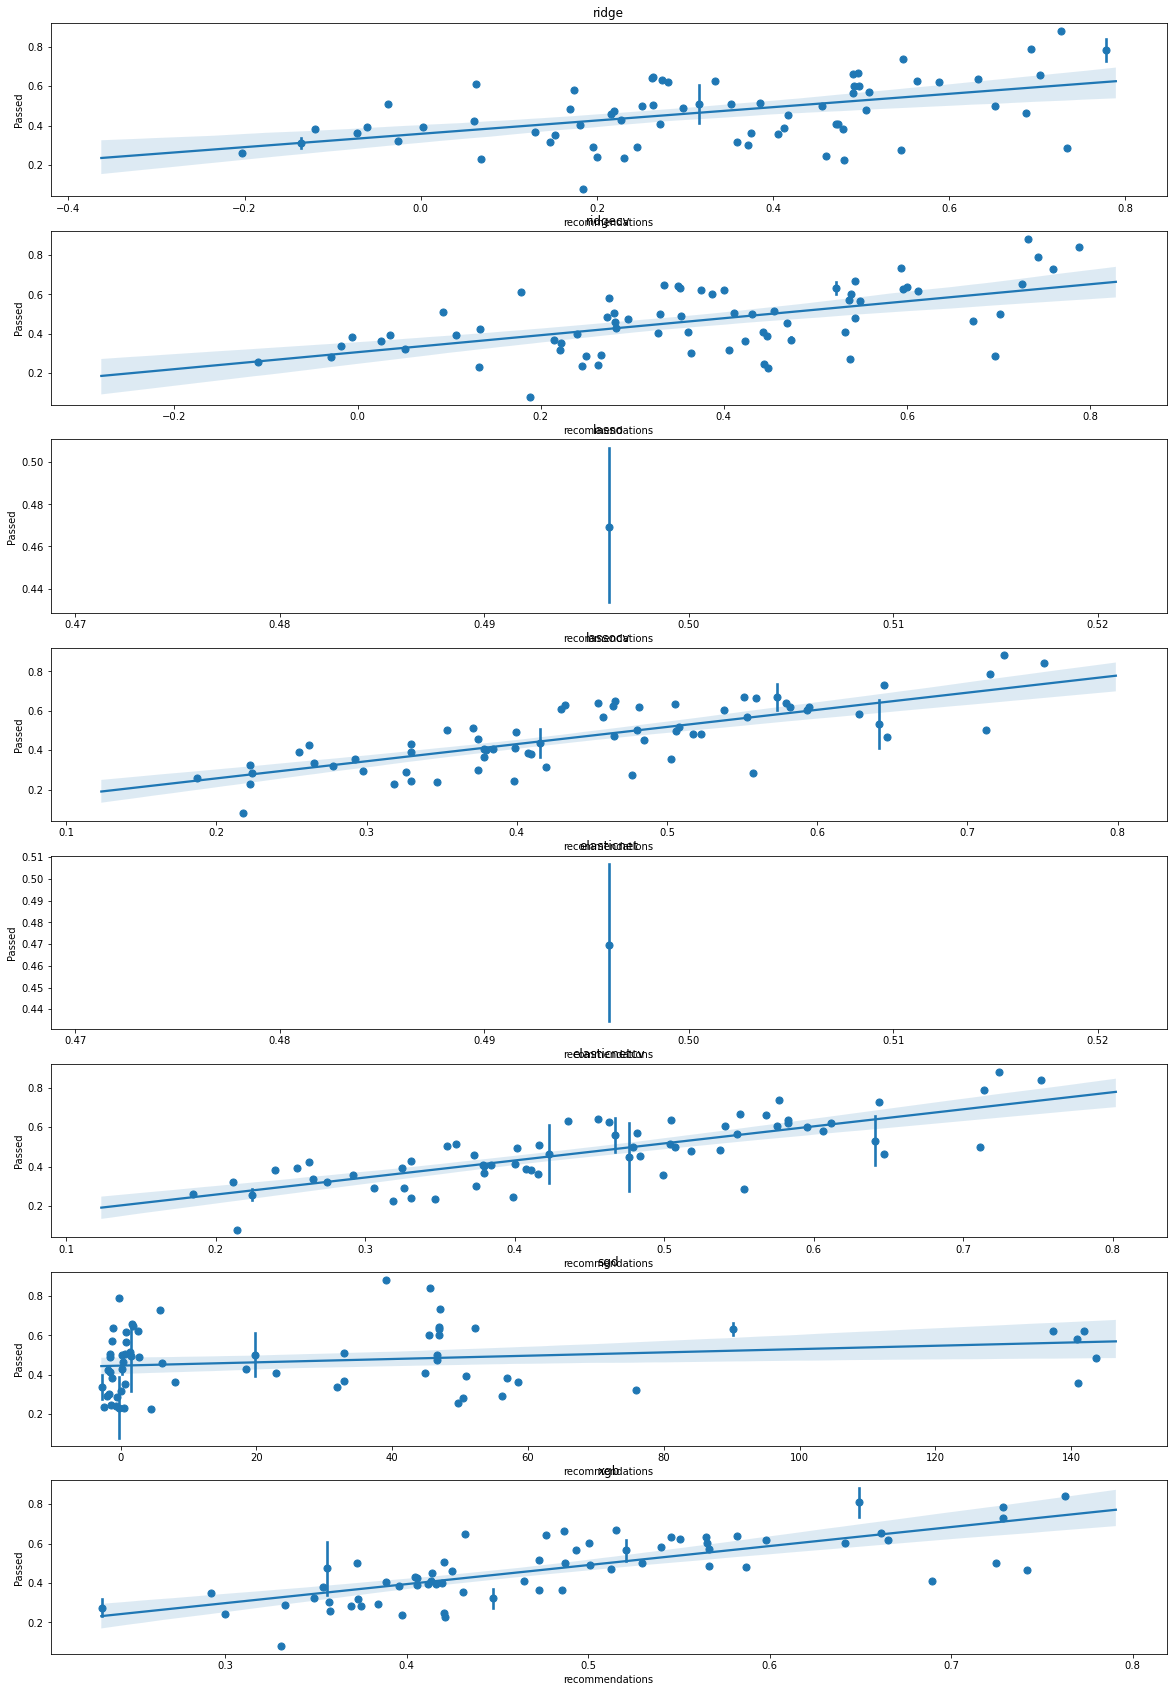

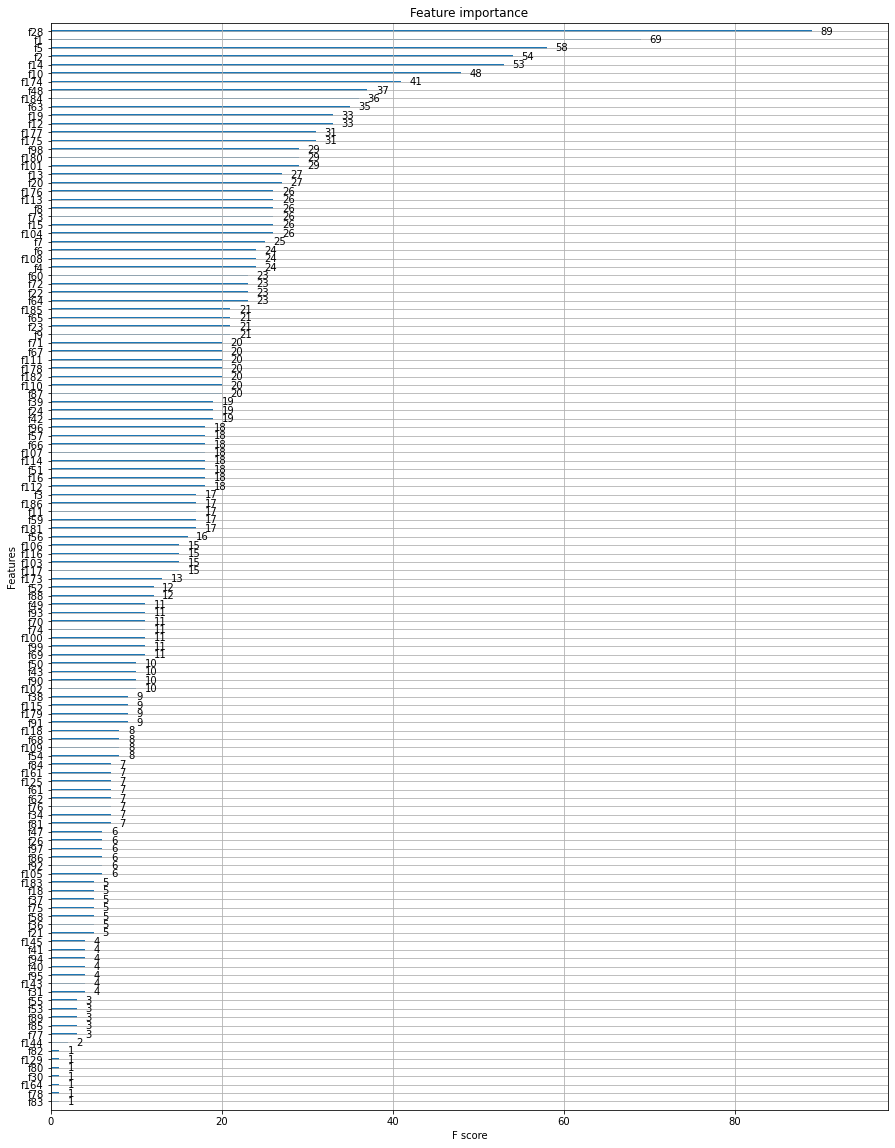

In [42]:
proz_regression(shuffle=False, scale_data=True)

ridge : 
r2_score 0.45460253663862293  
mse 0.013491368723352246  
mae 0.09328982007129419  


ridgecv : 
r2_score 0.5429502067973946  
mse 0.009743298025743133  
mae 0.07932996243535137  


lasso : 
r2_score -2.580582363498716e+30  
mse 0.031808133426046485  
mae 0.1521972511574074  


lassocv : 
r2_score 0.5500545552753242  
mse 0.008712436675320808  
mae 0.07429501911310174  


elasticnet : 
r2_score -2.580582363498716e+30  
mse 0.031808133426046485  
mae 0.1521972511574074  


elasticnetcv : 
r2_score 0.5436244285372881  
mse 0.008756448299060603  
mae 0.07460230625721691  


sgd : 
r2_score 0.540793261346924  
mse 0.009066859962539621  
mae 0.07589821382843431  


xgb : 
r2_score 0.5973979825114726  
mse 0.009400207458067598  
mae 0.0742473556674189  




([[Ridge(),
   'ridge',
   array([0.8405487 , 0.44890321, 0.60836483, 0.55616535, 0.33911857,
          0.39988116, 0.57045534, 0.58088529, 0.31574189, 0.40683181,
          0.45889234, 0.52623165, 0.65546453, 0.36711144, 0.45235961,
          0.54804334, 0.79890914, 0.2792813 , 0.45162808, 0.28244793,
          0.4392323 , 0.39145928, 0.4616668 , 0.75205166, 0.28269882,
          0.29639082, 0.43974013, 0.39630832, 0.3728915 , 0.49784714,
          0.50902771, 0.46691079, 0.69935634, 0.46199368, 0.2552605 ,
          0.38053458, 0.4820835 , 0.45186207, 0.37343335, 0.65445196,
          0.5214168 , 0.2653928 , 0.50728092, 0.61948586, 0.35668244,
          0.51601615, 0.64363793, 0.59505191, 0.42870588, 0.36264765,
          0.56374995, 0.65030915, 0.47092723, 0.8516824 , 0.39911277,
          0.79881656, 0.24055259, 0.47044056, 0.20814456, 0.68413851,
          0.71556697, 0.69371429, 0.53535945, 0.34006569, 0.66977318,
          0.5761907 , 0.12652334, 0.43172202, 0.57490563, 0.437582

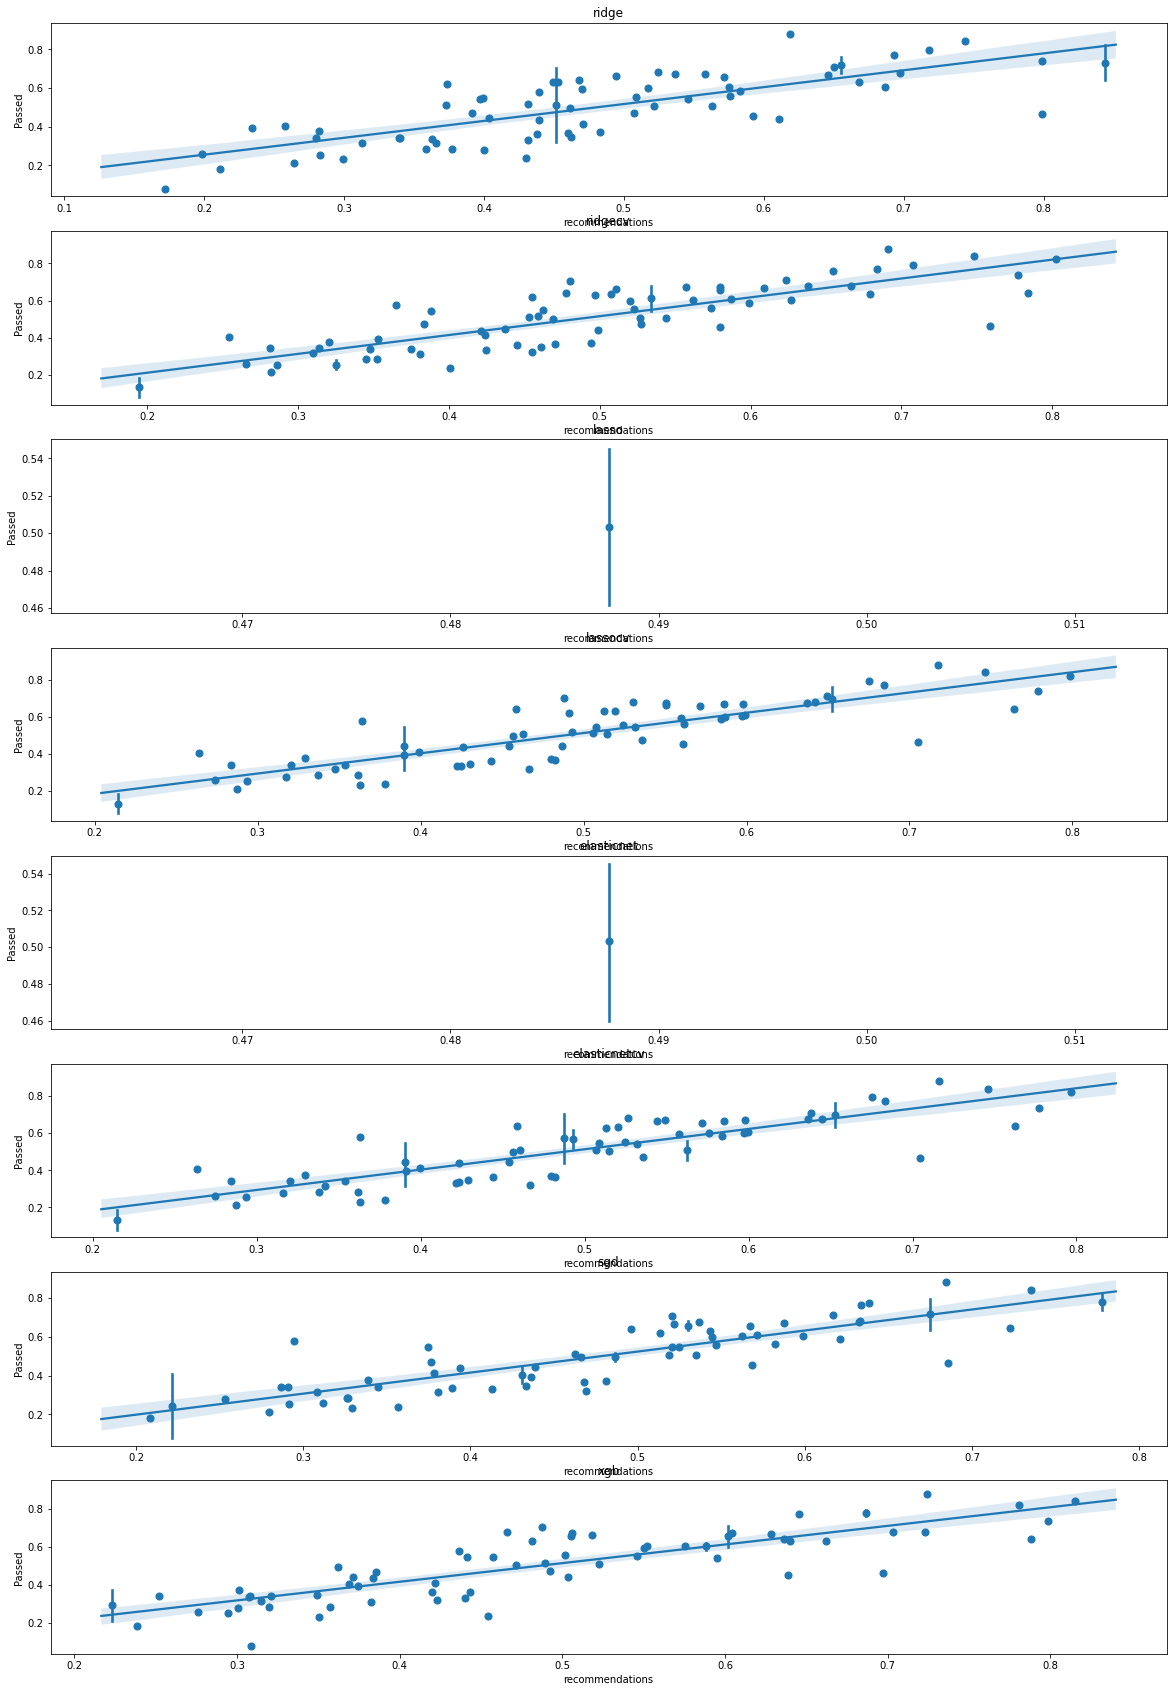

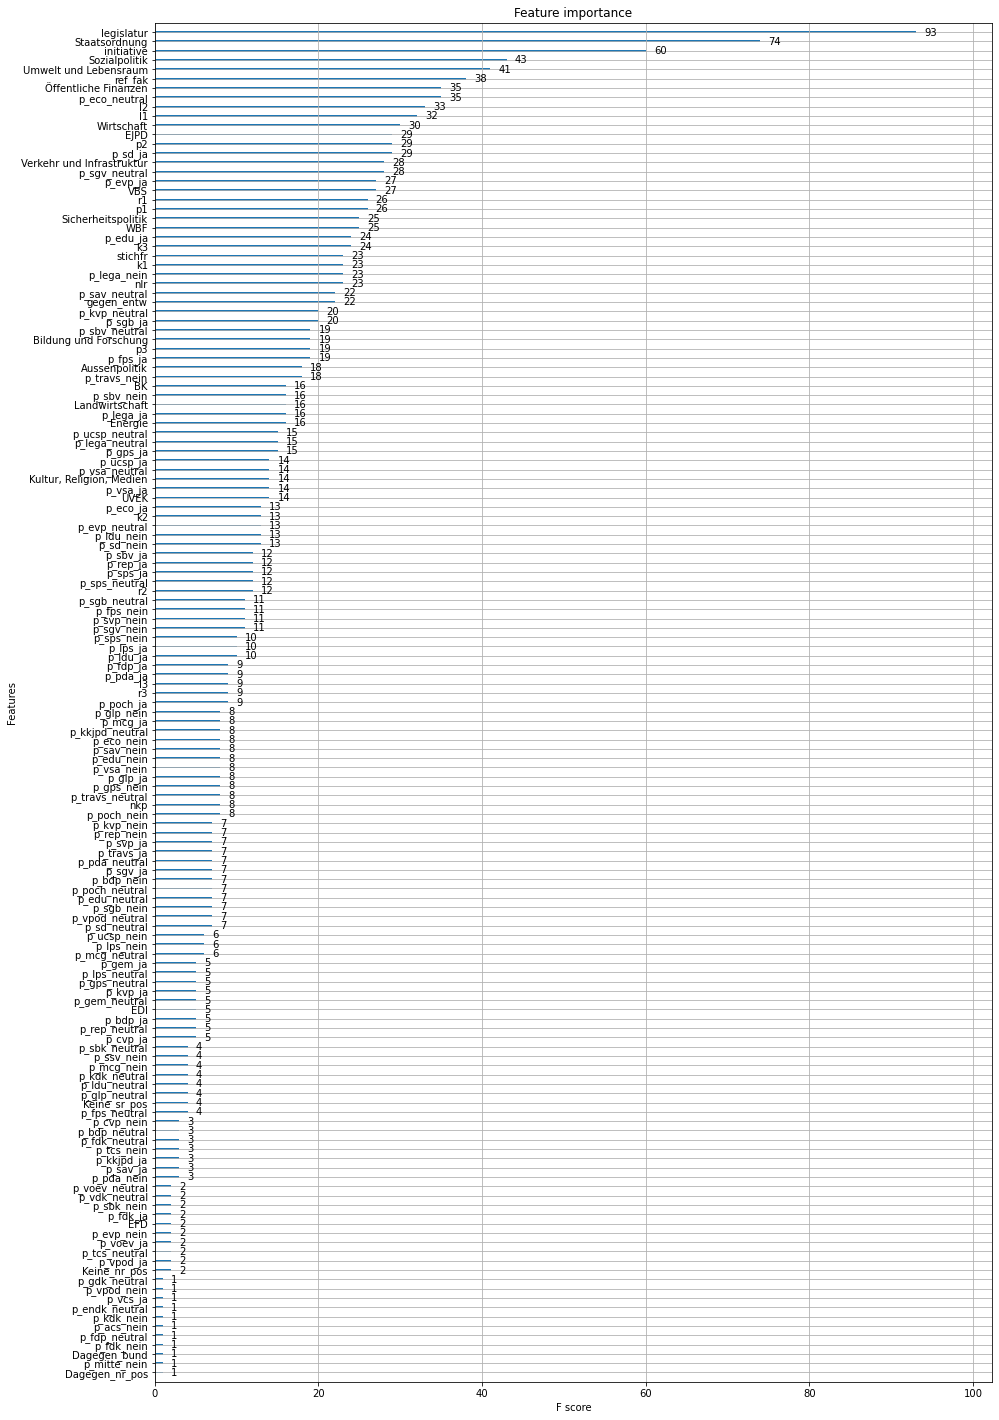

In [47]:
proz_regression(shuffle=True, visualisation=True)

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010605393630294113, tolerance: 0.0009161513237754387
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013407671397649423, tolerance: 0.0009161513237754387
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010768660384248285, tolerance: 0.0010092070747859652
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWar

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013349453230686592, tolerance: 0.0008801647127859649
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014028238804919546, tolerance: 0.0008801647127859649
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020372635009970885, tolerance: 0.0008801647127859649
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWar

ridge : 
r2_score 0.7221926276753232  
mse 0.005688702423780737  
mae 0.05514949499579326  


ridgecv : 
r2_score 0.6914269768531869  
mse 0.005888601813879948  
mae 0.06043064207295065  


lasso : 
r2_score 0.0  
mse 0.026746464252628277  
mae 0.13596295331790126  


lassocv : 
r2_score 0.5585738053651181  
mse 0.007474883177939381  
mae 0.06827467593700837  


elasticnet : 
r2_score 0.0  
mse 0.026746464252628277  
mae 0.13596295331790126  


elasticnetcv : 
r2_score 0.5906600918488951  
mse 0.00710687479324978  
mae 0.06742306888037788  


sgd : 
r2_score 0.45476704336566154  
mse 0.0073352265465939665  
mae 0.06881195967189895  


xgb : 
r2_score 0.9357036304664147  
mse 0.0014499445341593002  
mae 0.023871921394599798  




([[Ridge(),
   'ridge',
   array([0.34172767, 0.41451045, 0.76389145, 0.58520055, 0.27028316,
          0.56535615, 0.43965914, 0.43631113, 0.40544273, 0.24490441,
          0.23234588, 0.34429298, 0.14038331, 0.61846233, 0.44896013,
          0.29180934, 0.49323655, 0.40572965, 0.39650297, 0.3295207 ,
          0.51990829, 0.29538809, 0.14687437, 0.36064133, 0.51076396,
          0.64445983, 0.43487049, 0.40496443, 0.68060973, 0.39450375,
          0.58490633, 0.60621299, 0.52877369, 0.57401618, 0.80973163,
          0.50925212, 0.48391353, 0.84326433, 0.32170821, 0.31201166,
          0.70297026, 0.67665982, 0.41482117, 0.41232711, 0.45387754,
          0.34744319, 0.48226867, 0.39729049, 0.6196607 , 0.66281758,
          0.39975799, 0.53906786, 0.34776915, 0.56115024, 0.38604323,
          0.65277384, 0.64978071, 0.53438758, 0.32085577, 0.4570643 ,
          0.44435326, 0.47549921, 0.39555581, 0.41762464, 0.61200093,
          0.46206279, 0.52323685, 0.34612178, 0.48528067, 0.424463

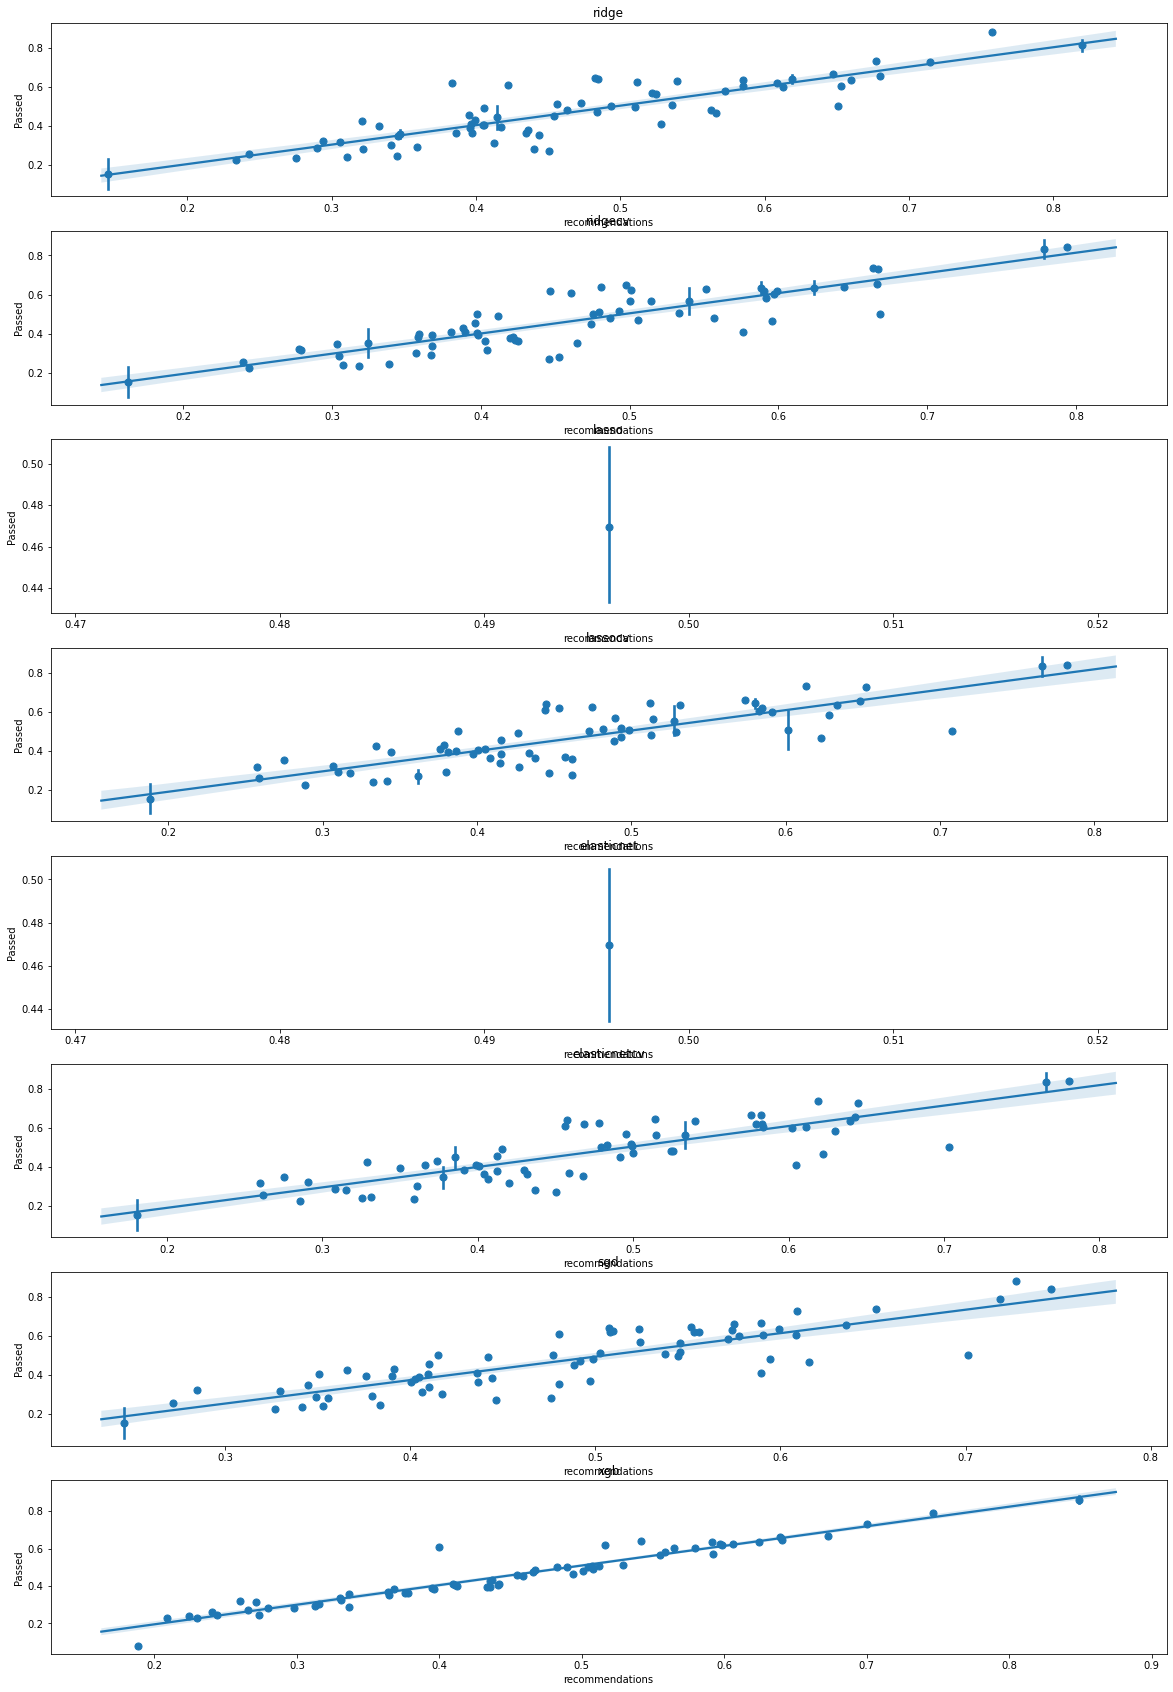

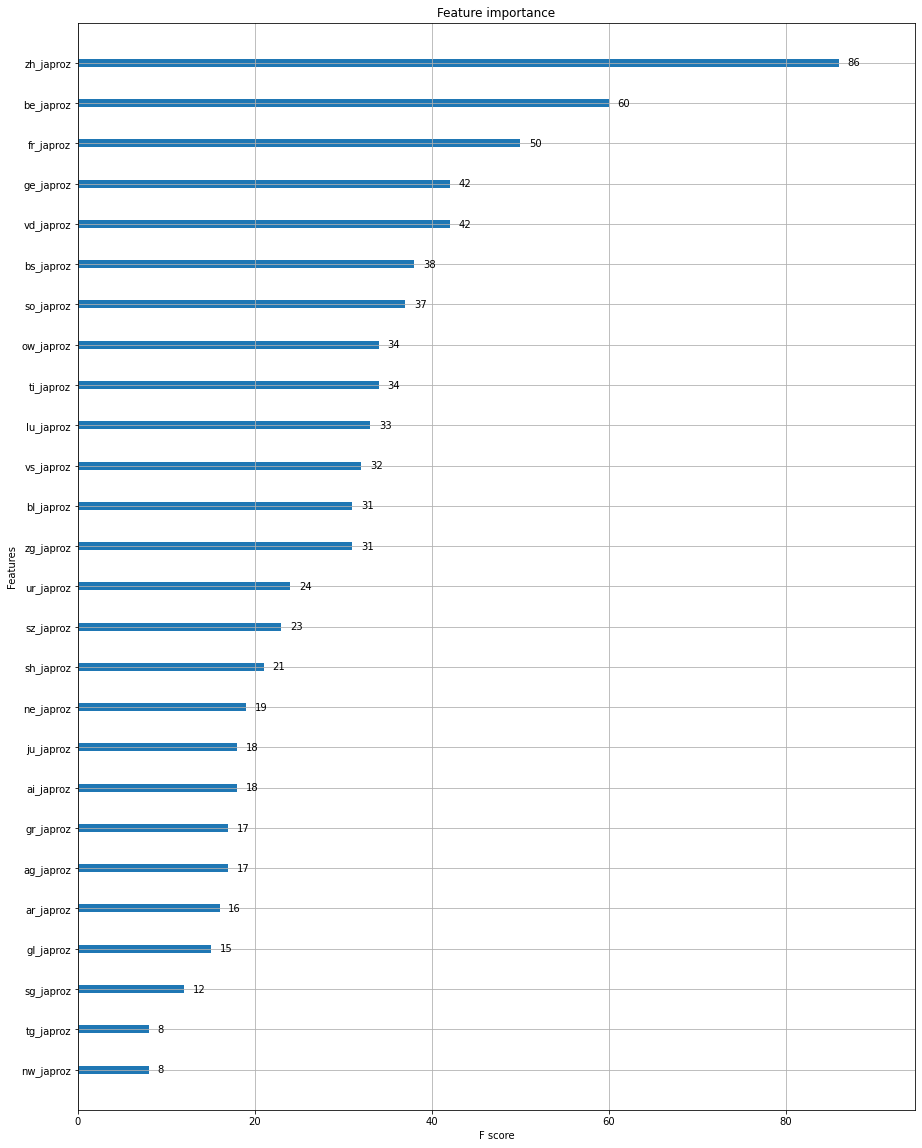

In [36]:
proz_regression_iv(shuffle=False)

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000956588038607098, tolerance: 0.0009154724361964913
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010229670917678568, tolerance: 0.0009706217183017545
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008912139157430943, tolerance: 0.0008623803141754388
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarn

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001182696194113264, tolerance: 0.0011814771051438598
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011949026492210635, tolerance: 0.0011814771051438598
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010909113692112449, tolerance: 0.0010008444016631581
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarn

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012649444849777147, tolerance: 0.0010642557643017543
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001192865851019409, tolerance: 0.0011290157764070174
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012680417606856231, tolerance: 0.0011290157764070174
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarn

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02716009284936316, tolerance: 0.0007483184952869565
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027012905016155386, tolerance: 0.0007483184952869565
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027286326211739542, tolerance: 0.0007483184952869565
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04205192305759198, tolerance: 0.000673120518973913
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04557961312076397, tolerance: 0.000673120518973913
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0489074612199607, tolerance: 0.000673120518973913
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Obje

D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02134028269175925, tolerance: 0.0007212167108917749
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01268974505641296, tolerance: 0.0007212167108917749
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017717709840880502, tolerance: 0.0007212167108917749
  model = cd_fast.enet_coordinate_descent_gram(
D:\IDE\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning:

ridge : 
r2_score -95.26034078802773  
mse 0.027352404112339204  
mae 0.13828065853986912  


ridgecv : 
r2_score -245.62254718381124  
mse 0.027958858763583647  
mae 0.14126564945284137  


lasso : 
r2_score 0.0  
mse 0.027776200614510995  
mae 0.13973055555555558  


lassocv : 
r2_score 0.0  
mse 0.027776200614510995  
mae 0.13973055555555558  


elasticnet : 
r2_score 0.0  
mse 0.027776200614510995  
mae 0.13973055555555558  


elasticnetcv : 
r2_score -228.89083422916403  
mse 0.027605385127939048  
mae 0.1395350045533218  


sgd : 
r2_score -3.1968691026619283  
mse 0.03398065774338096  
mae 0.1512495772522363  


xgb : 
r2_score -3.5923794949384042  
mse 0.04904444139323401  
mae 0.1866808994134267  




([[Ridge(),
   'ridge',
   array([0.47743406, 0.52967666, 0.48970134, 0.45982846, 0.47156248,
          0.50516637, 0.49669797, 0.51638978, 0.47245031, 0.49485118,
          0.47533485, 0.49543774, 0.50637394, 0.48777961, 0.46413849,
          0.51109378, 0.50316238, 0.51780418, 0.49616188, 0.50518474,
          0.5054643 , 0.51085374, 0.49934253, 0.49994825, 0.49954807,
          0.47733115, 0.4908614 , 0.50601829, 0.47906068, 0.489737  ,
          0.49464701, 0.49726554, 0.50104824, 0.46793677, 0.49715414,
          0.48539314, 0.50745334, 0.49883585, 0.51802414, 0.46790133,
          0.51161209, 0.48317079, 0.50762785, 0.46974319, 0.51901577,
          0.48995861, 0.45751448, 0.49614118, 0.48617356, 0.47835096,
          0.46708456, 0.50457579, 0.49834641, 0.49333312, 0.50735119,
          0.51624994, 0.48744229, 0.5117505 , 0.46748814, 0.47667849,
          0.48691754, 0.4751794 , 0.5013382 , 0.50536851, 0.51879808,
          0.51546723, 0.46586341, 0.48431408, 0.5252947 , 0.489077

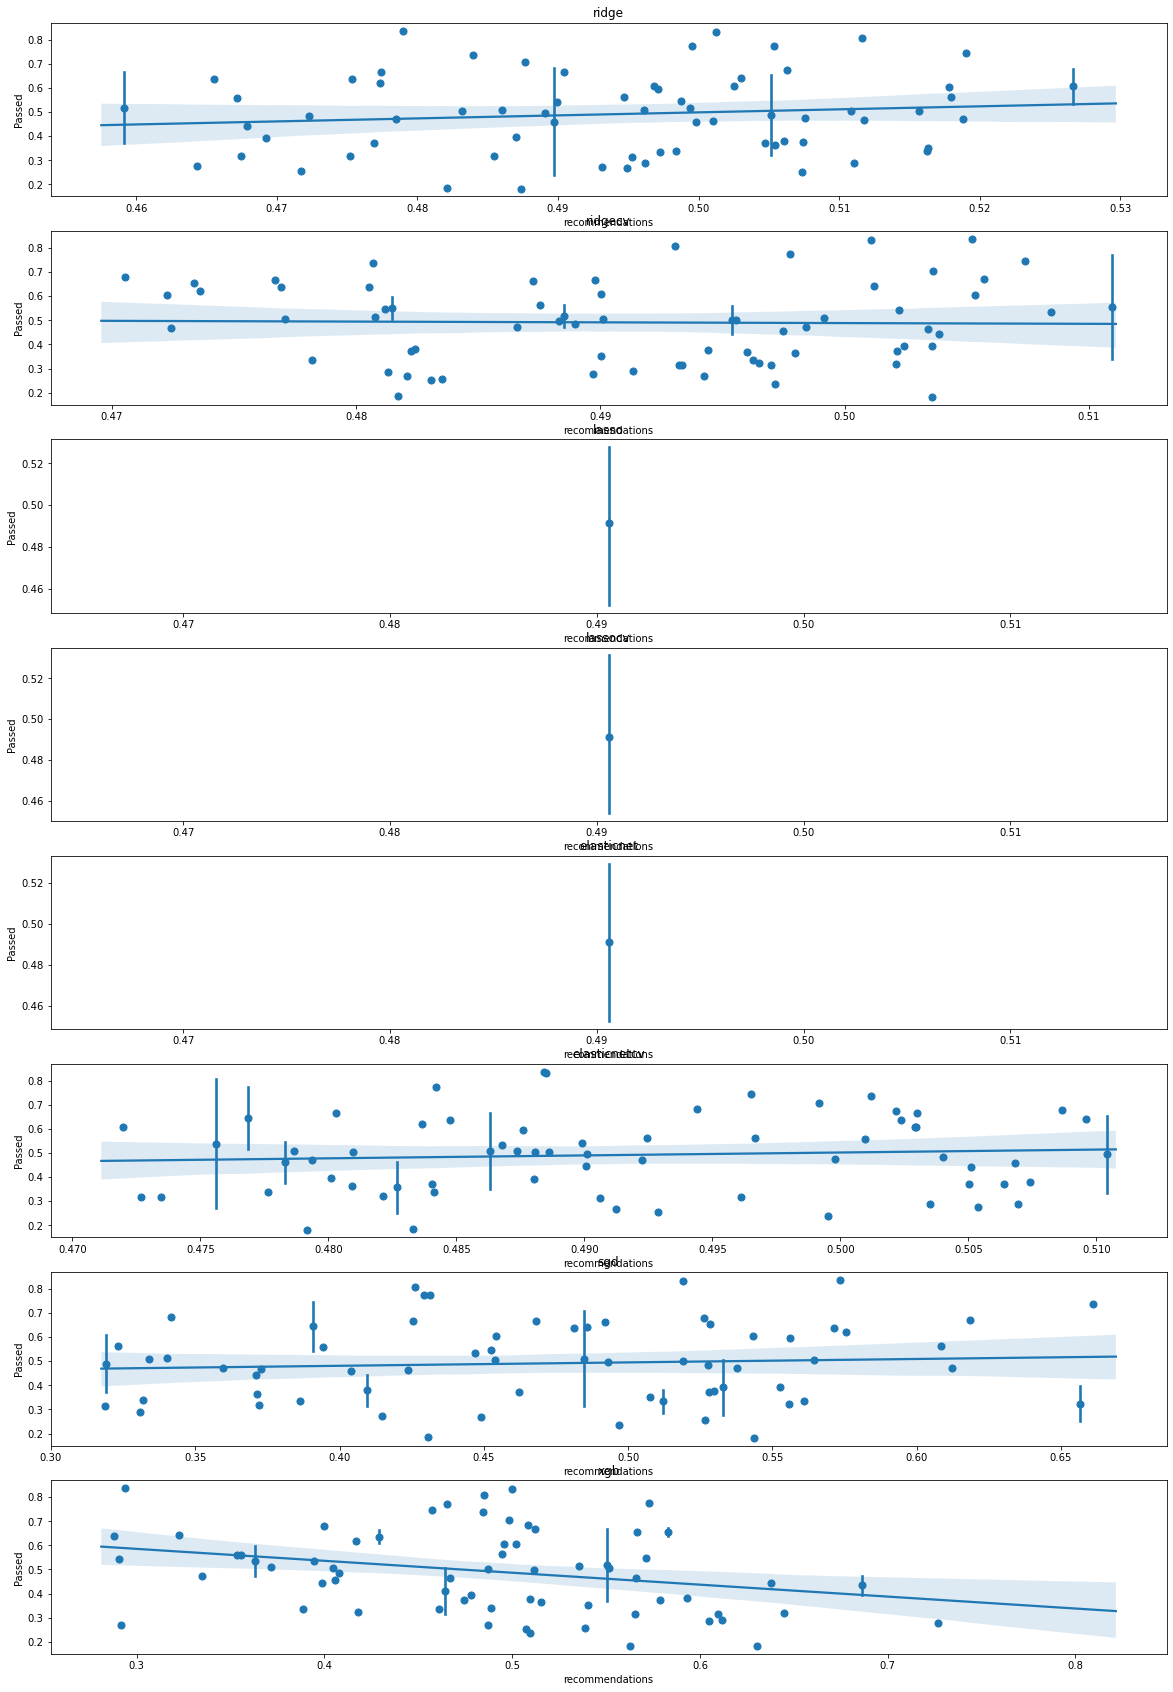

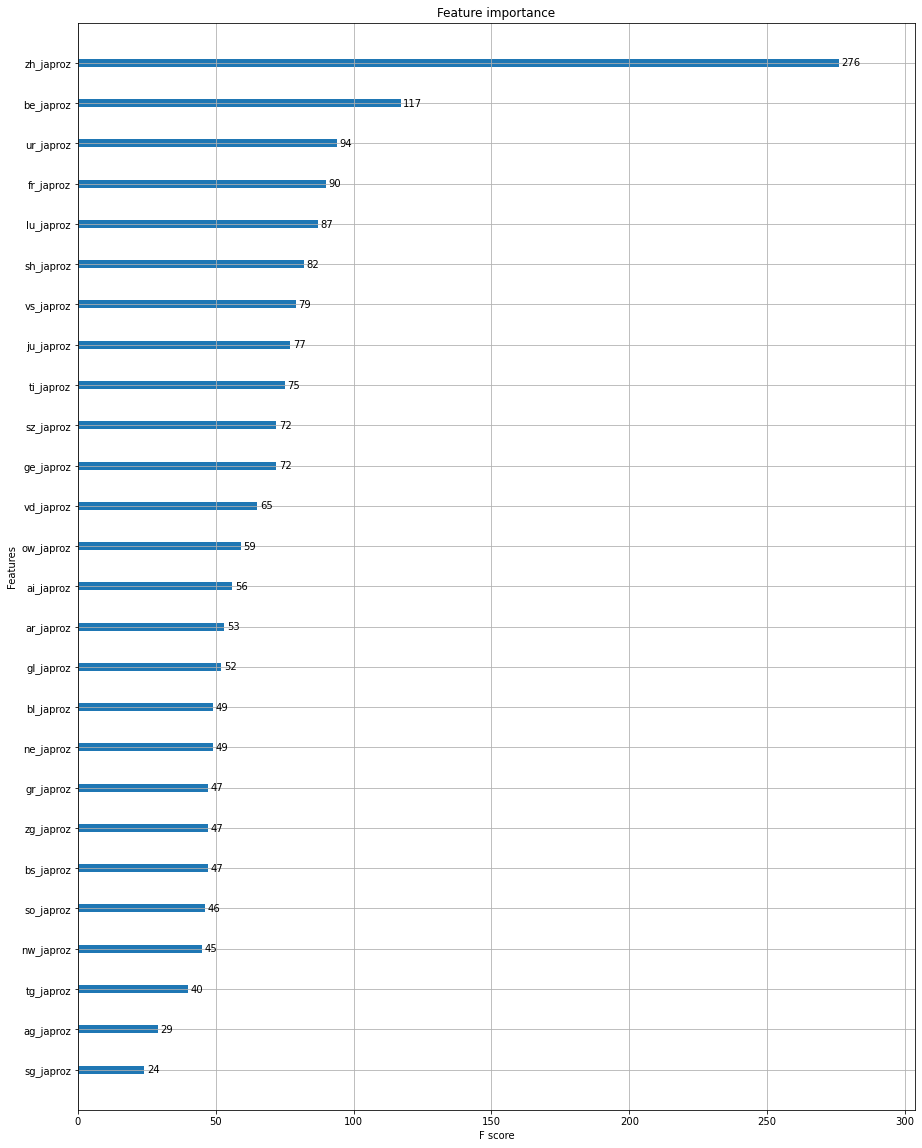

In [37]:
proz_regression_iv(shuffle=True)

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ridge : 
r2_score -0.11038961038961026  
mse 0.2638888888888889  
mae 0.2638888888888889  


ridgecv : 
r2_score 0.12337662337662358  
mse 0.20833333333333334  
mae 0.20833333333333334  


sgd : 
r2_score -0.16666666666666674  
mse 0.2916666666666667  
mae 0.2916666666666667  


xgb : 
r2_score 0.2571428571428571  
mse 0.18055555555555555  
mae 0.18055555555555555  




([[RidgeClassifier(),
   'ridge',
   array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
          0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
          1, 0, 1, 0, 0, 1])],
  [RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
   'ridgecv',
   array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
          0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
          1, 0, 0, 0, 0, 0])],
  [SGDClassifier(loss='log', penalty='elasticnet'),
   'sgd',
   array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
          0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
          1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
          1, 0, 1, 1, 0, 0])],
  [XGBClassifier(base_score=0.5, booster='gbtree', colsam

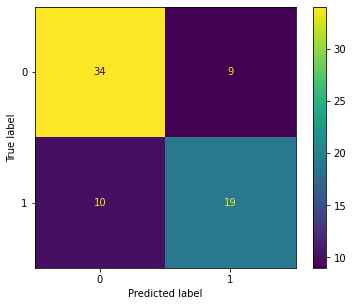

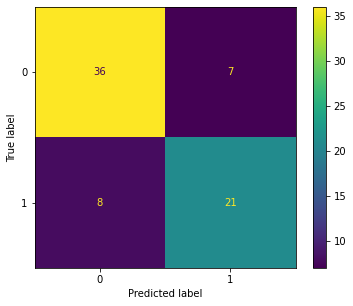

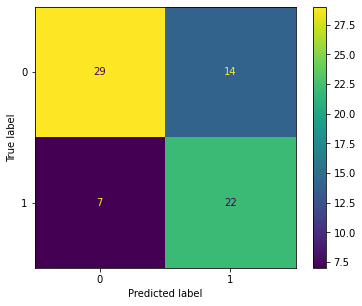

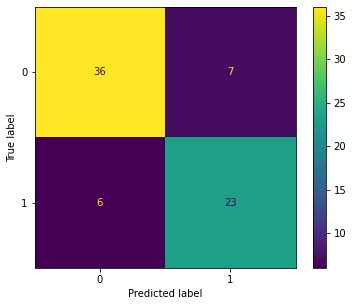

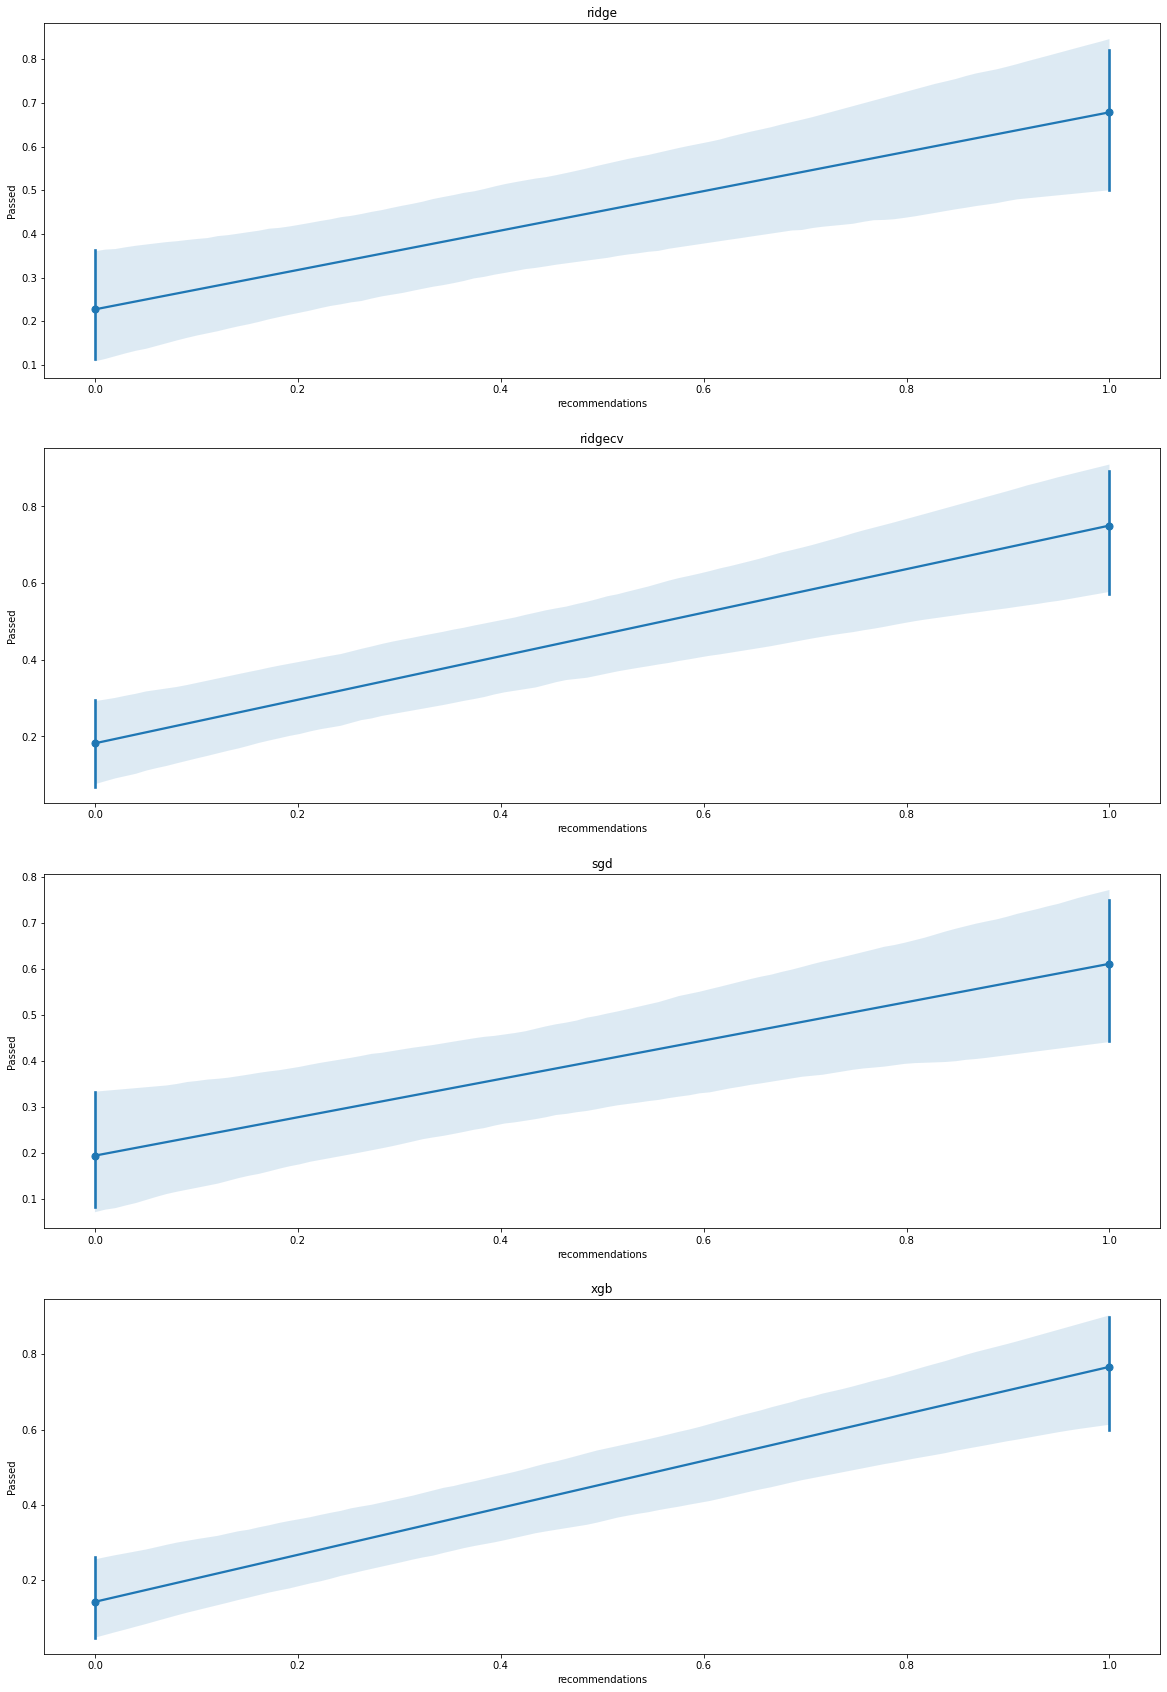

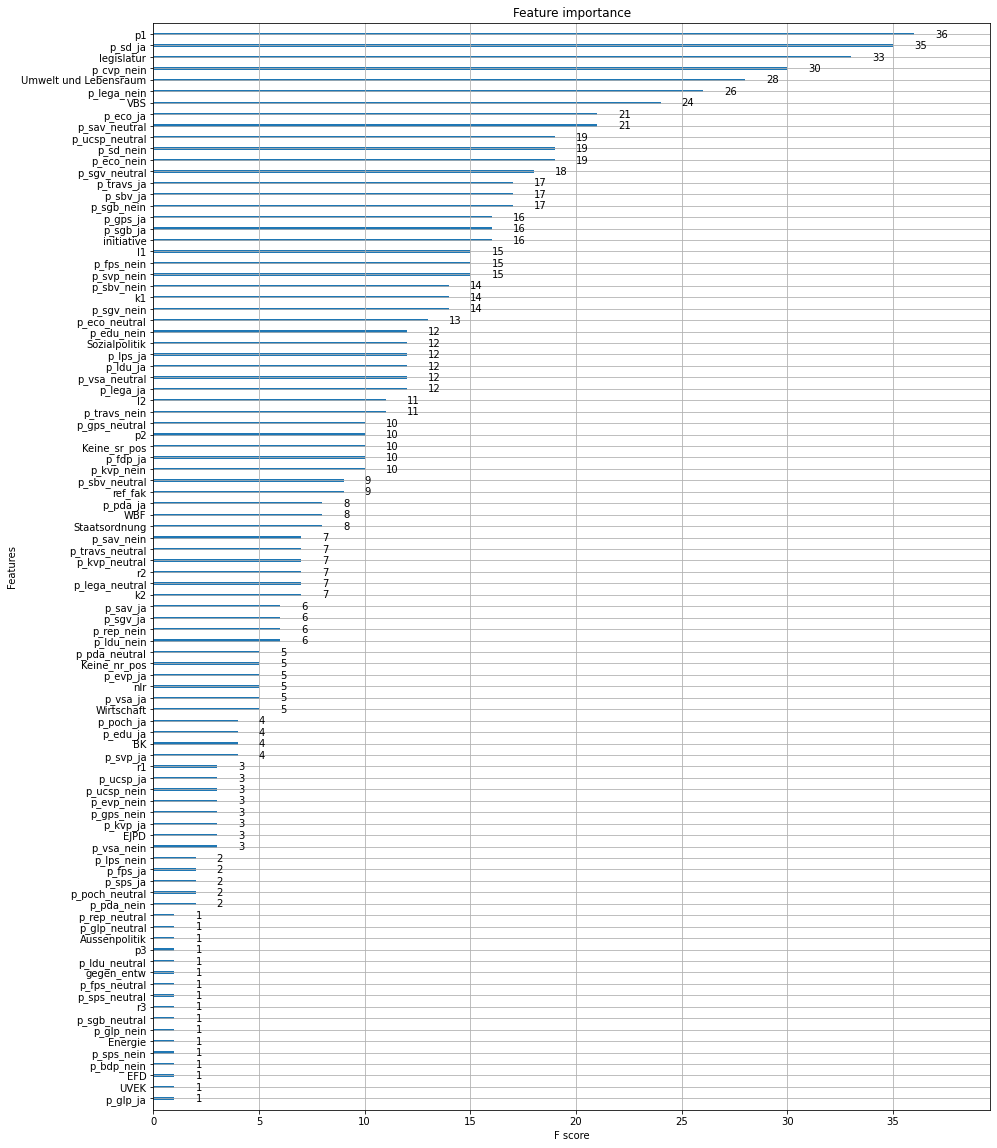

In [38]:
binary_classifier(shuffle=False)

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ridge : 
r2_score -0.11455108359133104  
mse 0.2777777777777778  
mae 0.2777777777777778  


ridgecv : 
r2_score 0.2727272727272727  
mse 0.18055555555555555  
mae 0.18055555555555555  


sgd : 
r2_score -0.2857142857142858  
mse 0.3055555555555556  
mae 0.3055555555555556  


xgb : 
r2_score 0.2198142414860681  
mse 0.19444444444444445  
mae 0.19444444444444445  




([[RidgeClassifier(),
   'ridge',
   array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
          0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
          1, 1, 0, 1, 0, 0])],
  [RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
   'ridgecv',
   array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
          0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
          1, 0, 0, 1, 0, 0])],
  [SGDClassifier(loss='log', penalty='elasticnet'),
   'sgd',
   array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
          0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
          1, 1, 1, 1, 0, 0])],
  [XGBClassifier(base_score=0.5, booster='gbtree', colsam

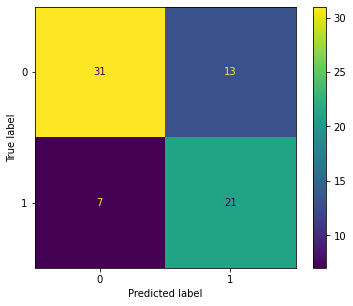

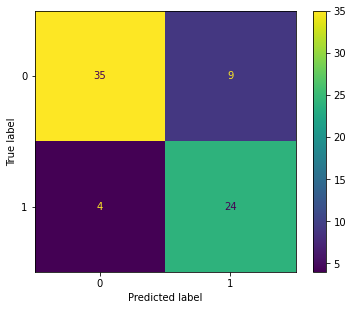

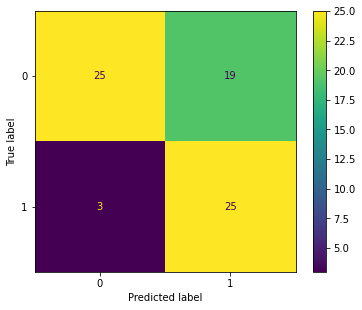

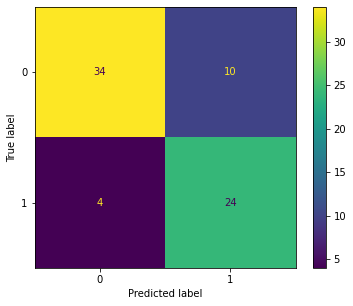

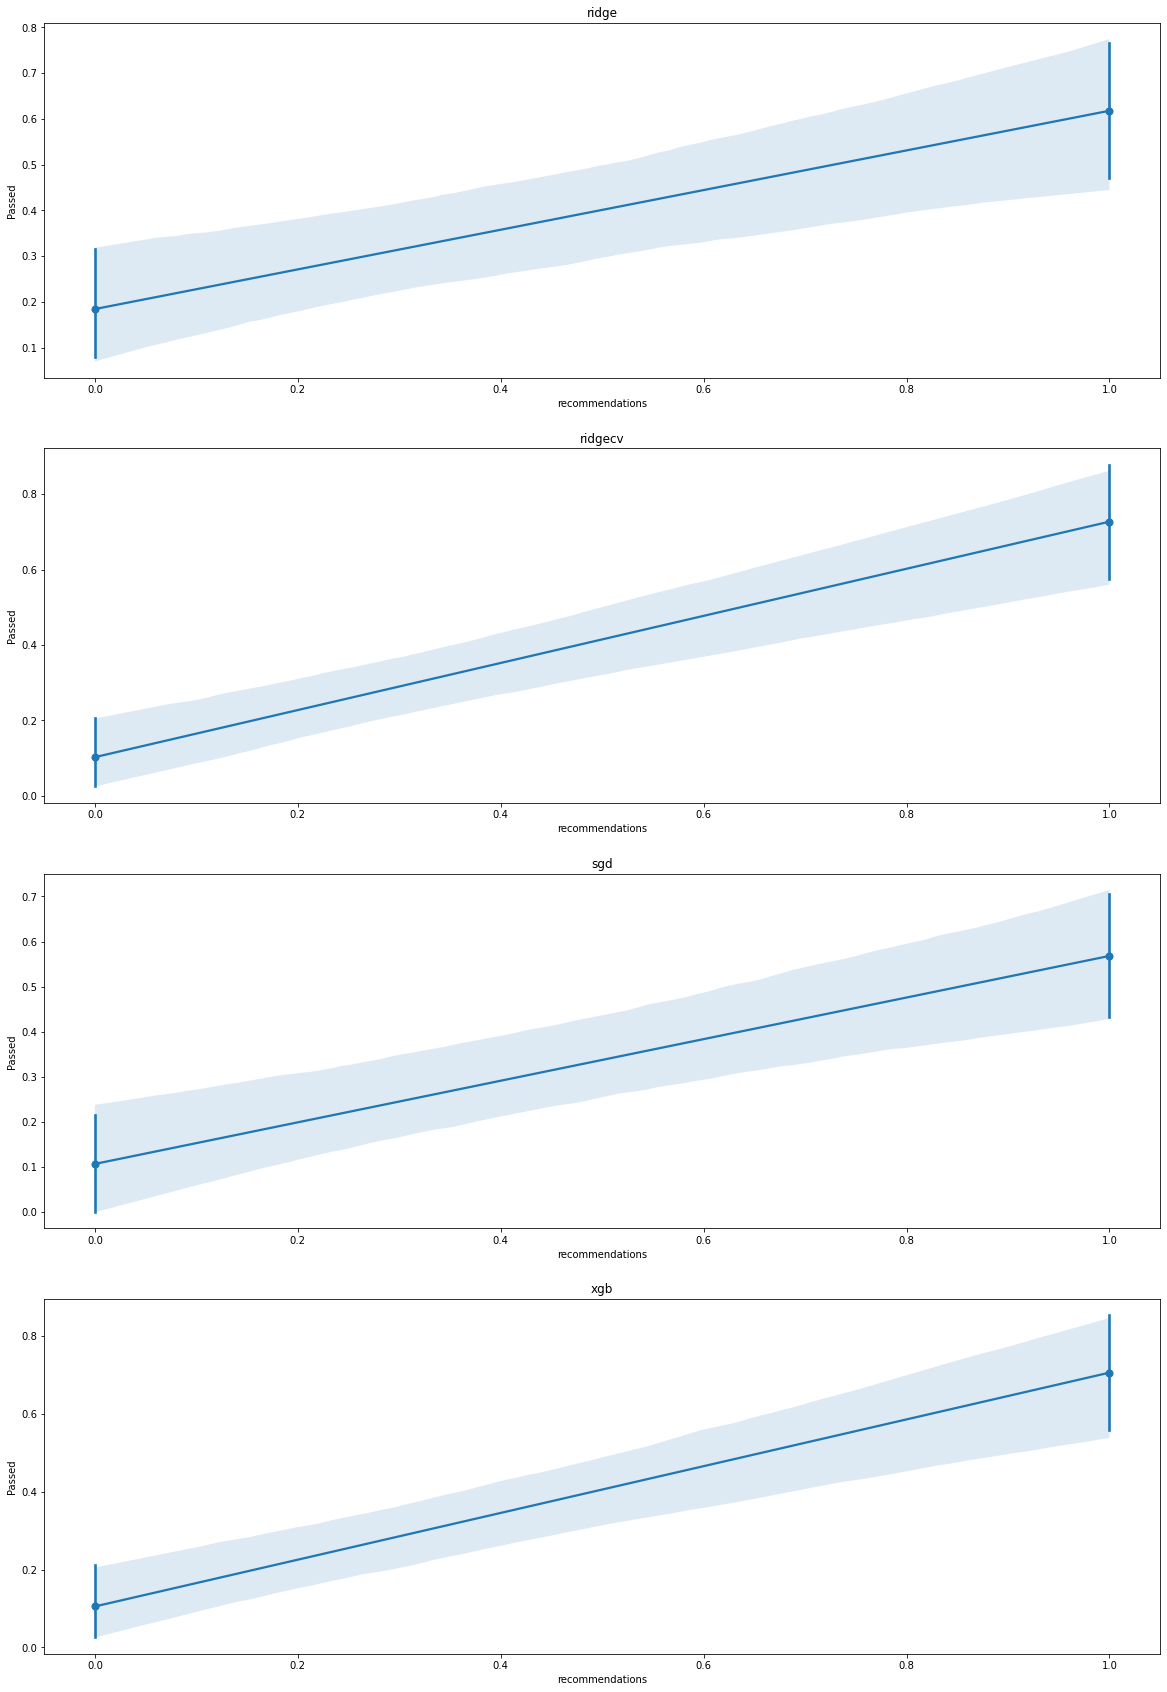

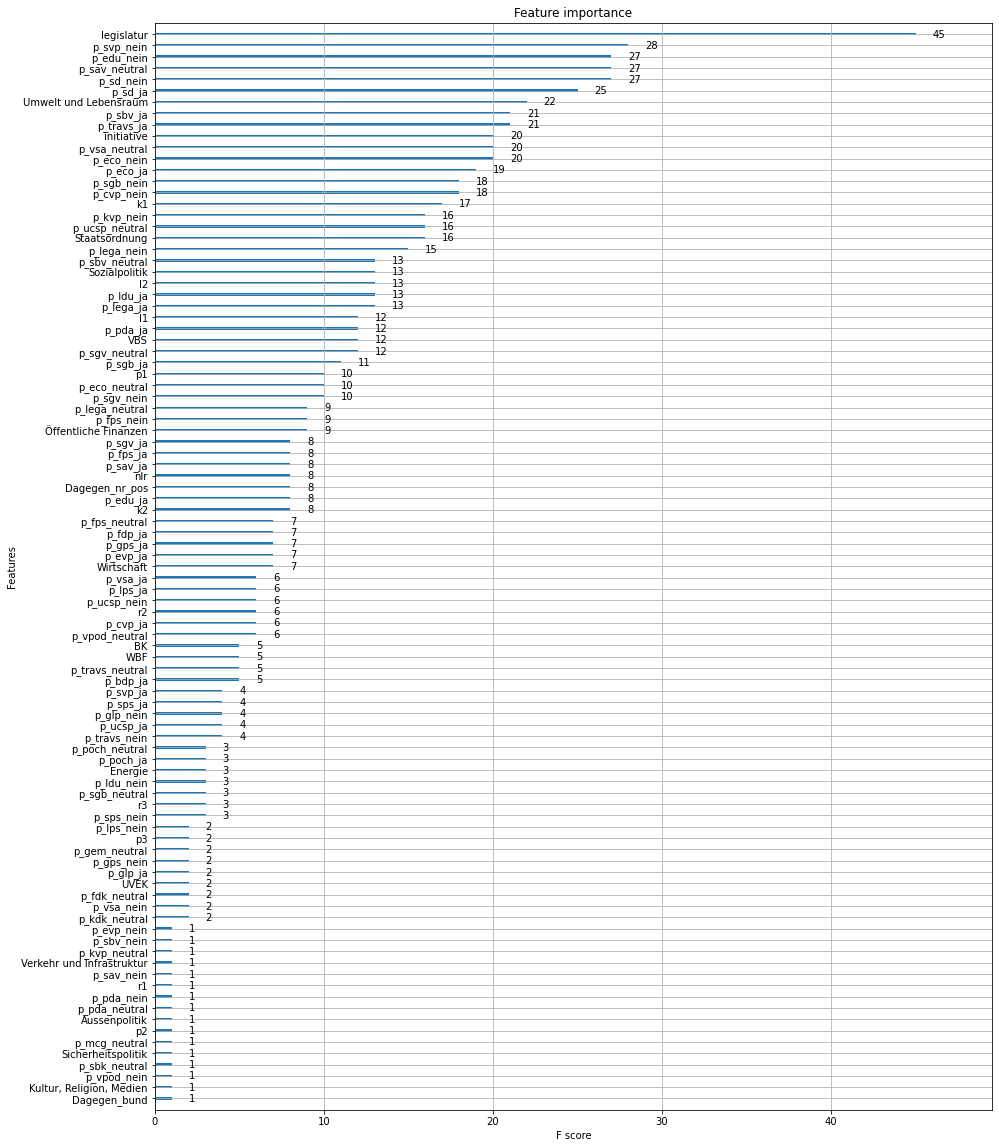

In [39]:
binary_classifier(shuffle=True)

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


([[RidgeClassifier(),
   'ridge',
   array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
          1, 0, 1, 0, 0, 0])],
  [RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
   'ridgecv',
   array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
          1, 0, 1, 0, 0, 0])],
  [SGDClassifier(loss='log', penalty='elasticnet'),
   'sgd',
   array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
          1, 0, 1, 0, 0, 0])],
  [XGBClassifier(base_score=0.5, booster='gbtree', colsam

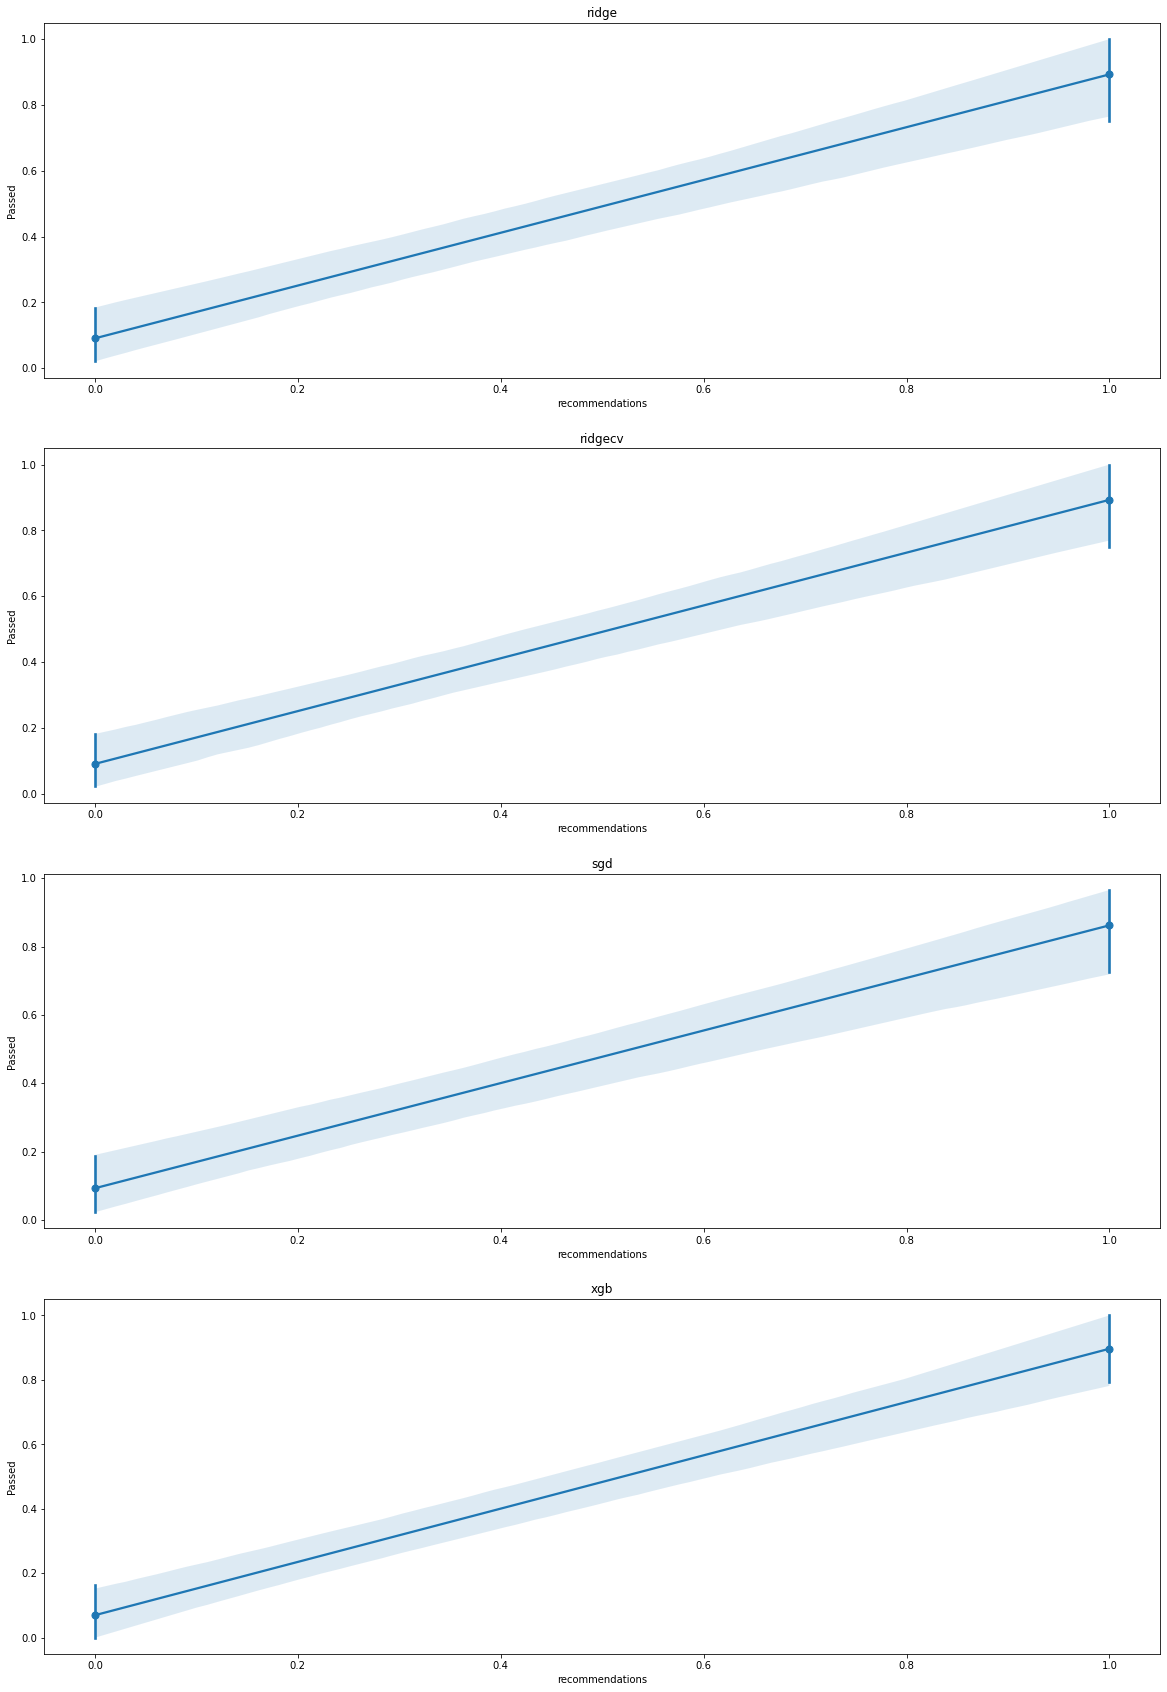

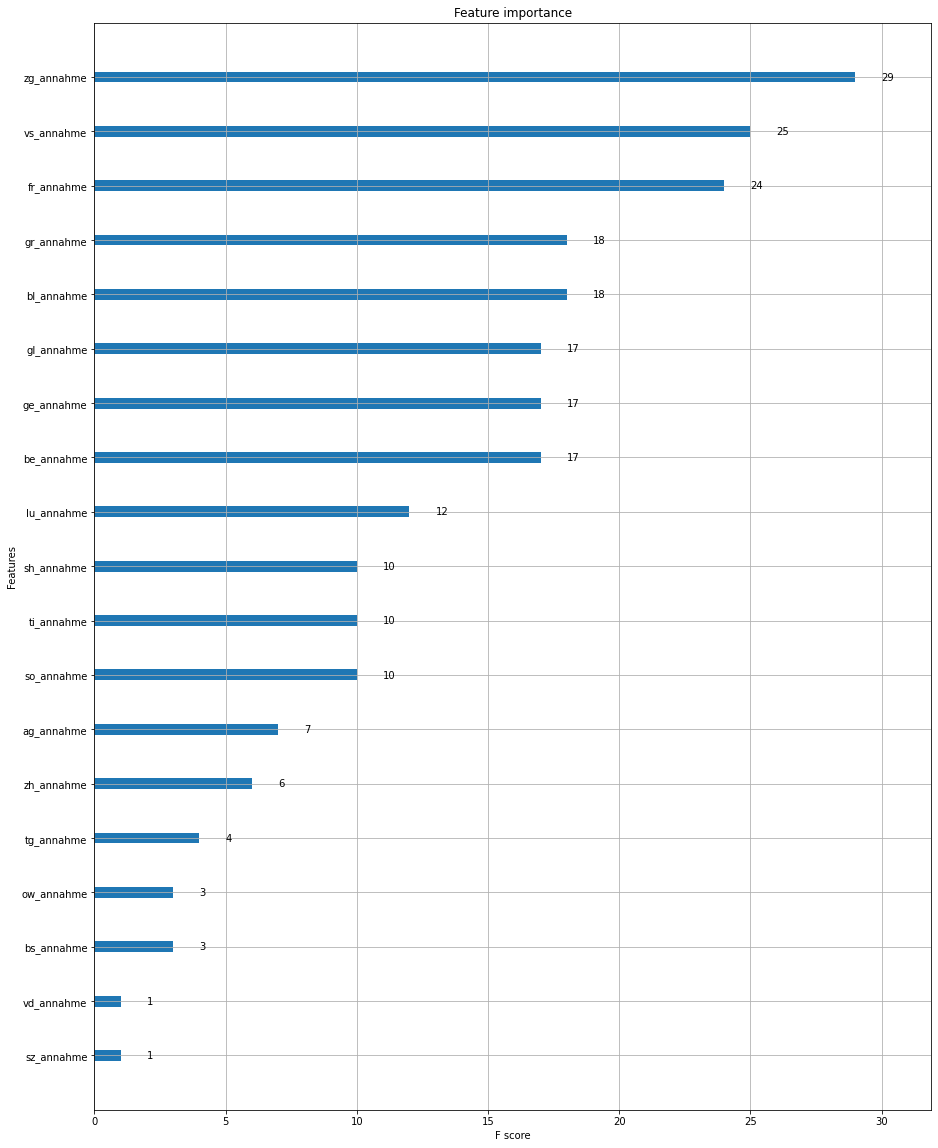

In [40]:
binary_classifier_iv(shuffle=False)

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:28:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

D:\IDE\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)




ridgecv : 
r2_score -1.0769230769230766  
mse 0.4166666666666667  
mae 0.4166666666666667  


sgd : 
r2_score -1.7321428571428568  
mse 0.4722222222222222  
mae 0.4722222222222222  


xgb : 
r2_score -1.006191950464396  
mse 0.5  
mae 0.5  




([[RidgeClassifier(),
   'ridge',
   array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
          1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
          0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
          1, 0, 1, 0, 1, 0])],
  [RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
   'ridgecv',
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
          0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
          1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
          1, 0, 0, 0, 0, 0])],
  [SGDClassifier(loss='log', penalty='elasticnet'),
   'sgd',
   array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
          0, 0, 1, 0, 0, 0])],
  [XGBClassifier(base_score=0.5, booster='gbtree', colsam

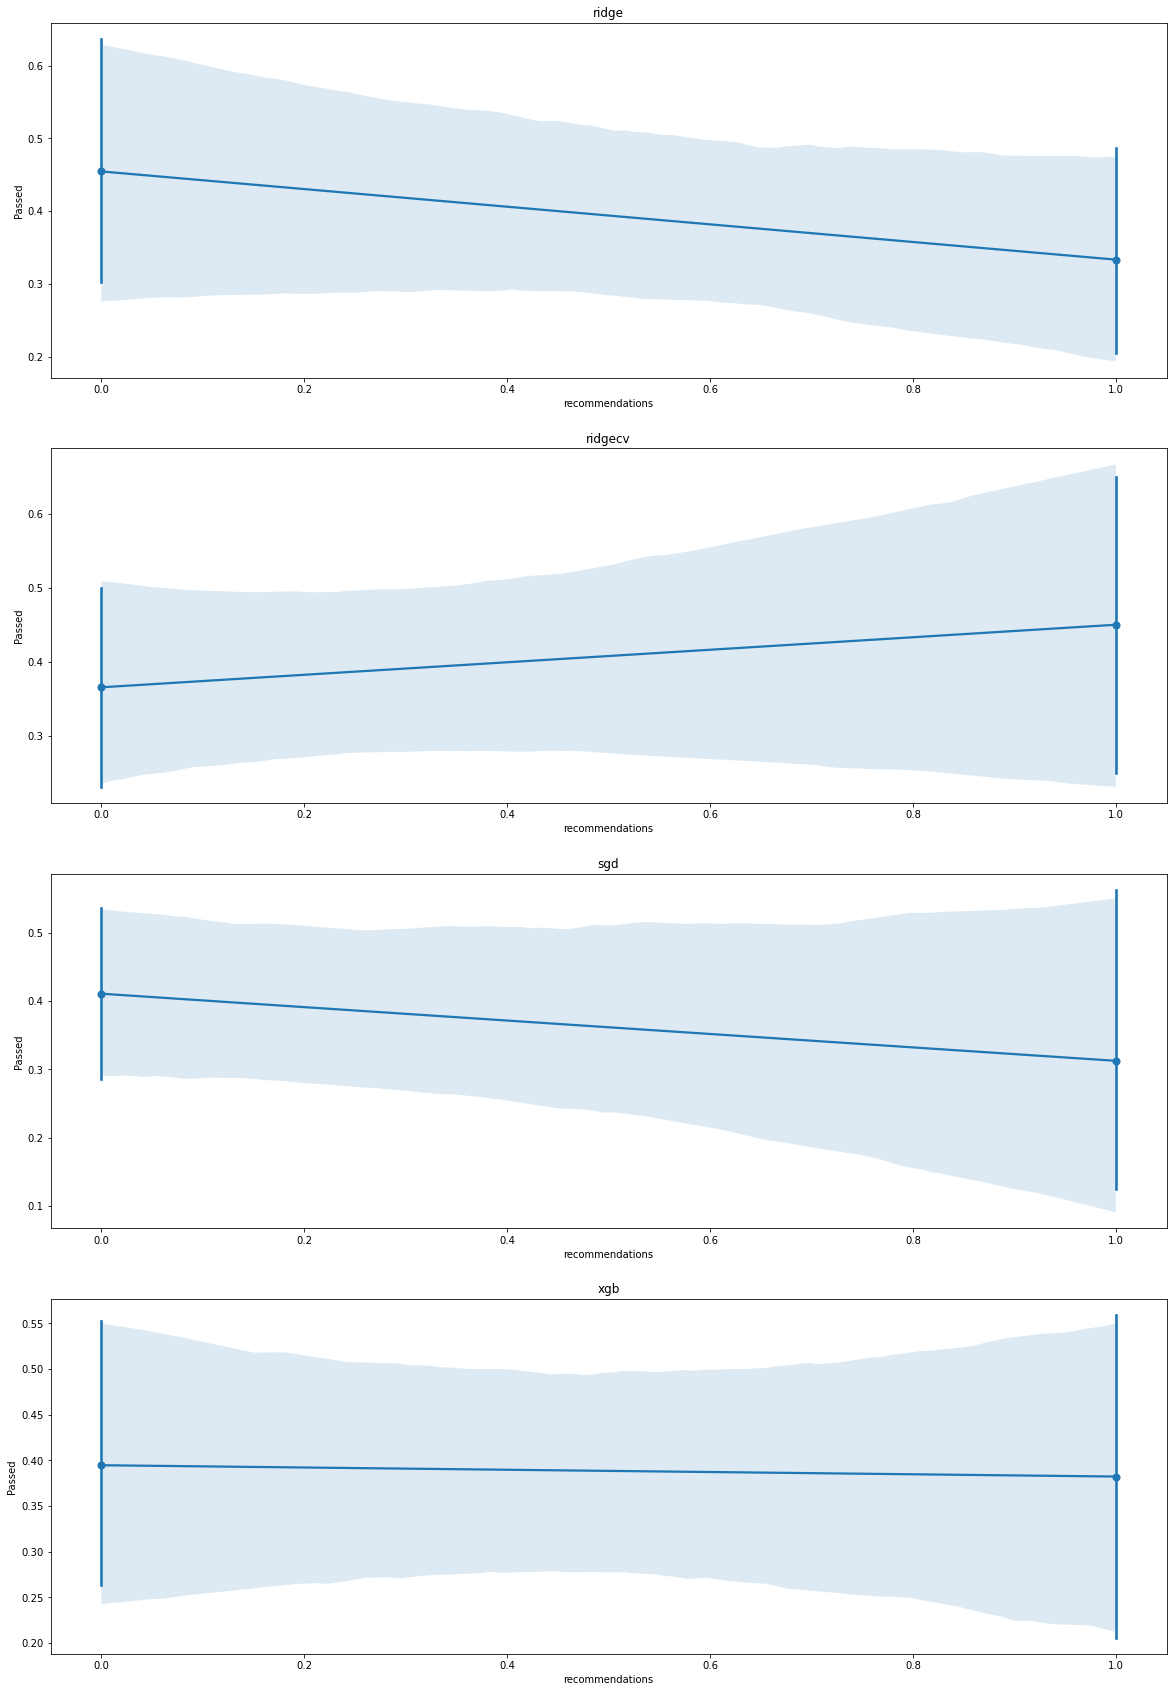

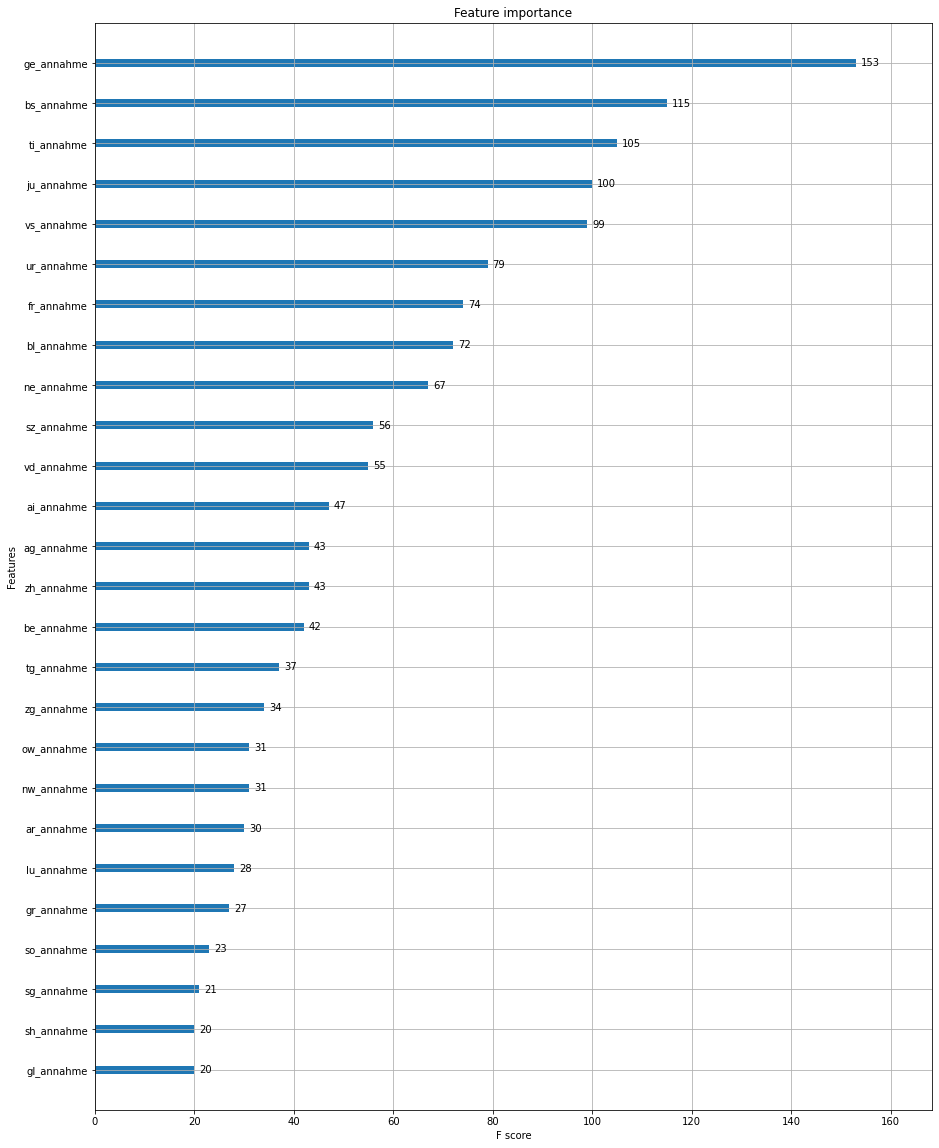

In [41]:
binary_classifier_iv(shuffle=True)